# Download repo

In [15]:
! git clone https://github.com/muxitox/nanoGPT.git

Cloning into 'nanoGPT'...
remote: Enumerating objects: 1109, done.
remote: Total 1109 (delta 0), reused 0 (delta 0), pack-reused 1109 (from 2)
Receiving objects: 100% (1109/1109), 6.12 MiB | 32.79 MiB/s, done.
Resolving deltas: 100% (526/526), done.


In [16]:
%cd nanoGPT

/kaggle/working/nanoGPT/nanoGPT


In [17]:
!git pull

Already up to date.


In [18]:
!pwd

/kaggle/working/nanoGPT/nanoGPT


# Install dependencies

In [19]:
! pip install torch==2.2.2 torchvision torchaudio numpy transformers datasets tiktoken wandb tqdm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 5.5 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf-cu12 24.12.0 requires pyarrow<19.0.0a0,>=14.0.0; platform_machine == "x86_64", but you have pyarrow 19.0.0 which is incompatible.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.


In [20]:
! pip install fsspec==2024.10.0

  Using cached fsspec-2024.10.0-py3-none-any.whl.metadata (11 kB)
Using cached fsspec-2024.10.0-py3-none-any.whl (179 kB)
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.9.0
    Uninstalling fsspec-2024.9.0:
      Successfully uninstalled fsspec-2024.9.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf-cu12 24.12.0 requires pyarrow<19.0.0a0,>=14.0.0; platform_machine == "x86_64", but you have pyarrow 19.0.0 which is incompatible.
datasets 3.2.0 requires fsspec[http]<=2024.9.0,>=2023.1.0, but you have fsspec 2024.10.0 which is incompatible.


# Import packages

In [21]:
"""
Import required libraries
"""
import os
import pickle
from contextlib import nullcontext
import torch
import tiktoken
from model_tests import GPTConfig, GPT
import matplotlib.pyplot as plt
from scipy.stats import norm

# Config

In [22]:
# -----------------------------------------------------------------------------
init_from = 'gpt2' # either 'resume' (from an out_dir) or a gpt2 variant (e.g. 'gpt2-xl')
out_dir = 'out-shakespeare-gpu' # ignored if init_from is not 'resume'


seed = 1337
device = 'cuda' if torch.cuda.is_available() else 'cpu' # examples: 'cpu', 'cuda', 'cuda:0', 'cuda:1', etc.
dtype = 'bfloat16' if torch.cuda.is_available() and torch.cuda.is_bf16_supported() else 'float32' # 'float32' or 'bfloat16' or 'float16'
compile = False # use PyTorch 2.0 to compile the model to be faster
# exec(open('configurator.py').read()) # overrides from command line or config file, not needed in this execution

In [23]:
# -----------------------------------------------------------------------------
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cuda.matmul.allow_tf32 = True # allow tf32 on matmul
torch.backends.cudnn.allow_tf32 = True # allow tf32 on cudnn
device_type = 'cuda' if 'cuda' in device else 'cpu' # for later use in torch.autocast
ptdtype = {'float32': torch.float32, 'bfloat16': torch.bfloat16, 'float16': torch.float16}[dtype]
ctx = nullcontext() if device_type == 'cpu' else torch.amp.autocast(device_type=device_type, dtype=ptdtype)

In [24]:
# model
if init_from == 'resume':
    # init from a model saved in a specific directory
    ckpt_path = os.path.join(out_dir, 'ckpt.pt')
    checkpoint = torch.load(ckpt_path, map_location=device)
    gptconf = GPTConfig(**checkpoint['model_args'])
    model = GPT(gptconf, compute_statistics=True)
    state_dict = checkpoint['model']
    unwanted_prefix = '_orig_mod.'
    for k,v in list(state_dict.items()):
        if k.startswith(unwanted_prefix):
            state_dict[k[len(unwanted_prefix):]] = state_dict.pop(k)
    model.load_state_dict(state_dict)
elif init_from.startswith('gpt2'):
    # init from a given GPT-2 model
    model = GPT.from_pretrained(init_from, dict(dropout=0.0))

loading weights from pretrained gpt: gpt2
forcing vocab_size=50257, block_size=1024, bias=True
overriding dropout rate to 0.0
number of parameters: 123.65M


### Load model

In [25]:
model.eval()
model.to(device)
if compile:
    model = torch.compile(model) # requires PyTorch 2.0 (optional)

In [26]:
# look for the meta pickle in case it is available in the dataset folder
load_meta = False
if init_from == 'resume' and 'config' in checkpoint and 'dataset' in checkpoint['config']: # older checkpoints might not have these...
    meta_path = os.path.join('data', checkpoint['config']['dataset'], 'meta.pkl')
    load_meta = os.path.exists(meta_path)
if load_meta:
    print(f"Loading meta from {meta_path}...")
    with open(meta_path, 'rb') as f:
        meta = pickle.load(f)
    # TODO want to make this more general to arbitrary encoder/decoder schemes
    stoi, itos = meta['stoi'], meta['itos']
    encode = lambda s: [stoi[c] for c in s]
    decode = lambda l: ''.join([itos[i] for i in l])
else:
    # ok let's assume gpt-2 encodings by default
    print("No meta.pkl found, assuming GPT-2 encodings...")
    enc = tiktoken.get_encoding("gpt2")
    encode = lambda s: enc.encode(s, allowed_special={"<|endoftext|>"})
    decode = lambda l: enc.decode(l)

No meta.pkl found, assuming GPT-2 encodings...


# Explore model

In [27]:
!pip install ipdb

In [28]:
def explore_model(start_text, temperature, top_k):

    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)

    # encode the beginning of the prompt
    if start_text.startswith('FILE:'):
        with open(start_text[5:], 'r', encoding='utf-8') as f:
            start_text = f.read()

    start_ids = encode(start_text)
    x = (torch.tensor(start_ids, dtype=torch.long, device=device)[None, ...])

    # run generation
    x_tensor = torch.zeros((num_samples, max_new_tokens, model.config.n_embd), device=device)
    q_tensor = torch.zeros((num_samples, max_new_tokens, model.config.n_head, model.config.n_embd // model.config.n_head), device=device)

    probs_accum = torch.zeros(model.config.vocab_size, device=device)


    num_mqk_plots = 9
    context_length = len(start_ids)
    # Get random indices of tokens from the context against which we'll compute statistics
    num_tau_probe = num_mqk_plots
    tau_probe_values = torch.randint(max(1, context_length - max_new_tokens), (num_tau_probe,))
    x_tau_values_tensor = torch.zeros((num_samples, num_tau_probe, model.config.n_embd), device=device)
    
    with torch.no_grad():
        with ctx:
            for k in range(num_samples):
                y, x_array, q_matrix, x_history,  probs_0 = model.generate_comp_stats(x, max_new_tokens, temperature=temperature, top_k=top_k)
                x_tensor[k] = x_array
                q_tensor[k] = q_matrix
                x_tau_values_tensor[k] = x_history[0, tau_probe_values]

                # Logits of the first computed token
                probs_accum += probs_0[0]

                log_steps = 10000
                if k % log_steps == 0:
                    print("Computing samples ", k, "to", k + log_steps)

                plot_samples = False
                if plot_samples:
                    print("Sample len", len(y[0].tolist()))
                    print('---------------')
                    print(decode(y[0].tolist()))
                    print('---------------')


        # Re-compute mean projection
        layer_i = 0
        # Get separate weights
        Wq, Wk, Wv = model.transformer.h[layer_i].attn.c_attn.weight.split(model.config.n_embd)

        # Divide weight in n_head heads
        Wq_h = Wq.view(model.config.n_head, model.config.n_embd // model.config.n_head, model.config.n_embd)
        Wk_h = Wk.view(model.config.n_head, model.config.n_embd // model.config.n_head, model.config.n_embd)
        Wv_h = Wv.view(model.config.n_head, model.config.n_embd // model.config.n_head, model.config.n_embd)
        W_list = [Wq_h, Wk_h, Wv_h]
        W_list_name = ["q", "k", "v"]


        # To get the projection for all the heads with some x, NOT CURRENTLY USED
        mq_h = torch.matmul( Wq_h, x_tensor[0, -1])


        #  Compute the mq, mk and mv averages
        fig, ax = plt.subplots(3, 3, constrained_layout=True)
        ax_ravel = ax.ravel()
        for i in range(0, 9):

            # Get W
            W = W_list[i // 3]

            # Examine feat feat_a from head h_i for different samples
            h_i = torch.randint(model.config.n_head, (1,))[0]
            feat_a = torch.randint(model.config.n_embd // model.config.n_head, (1,))[0]
            m_h_i_a = torch.matmul(W[h_i, feat_a], x_tensor[:, -1].T).cpu()

            # remove most probable occurrence
            uniques, counts = torch.unique(m_h_i_a, return_counts=True)
            mode_idx = torch.argmax(counts)
            mode_elem = uniques[mode_idx]
            m_h_i_a_no_mode = m_h_i_a[m_h_i_a!=mode_elem]

            # Get mean and std of the dist without mode
            mean_no_mode = m_h_i_a_no_mode.mean()
            std_no_mode = m_h_i_a_no_mode.std()


            # ipdb.set_trace()

            x_values_gauss = torch.linspace(m_h_i_a_no_mode.min(), m_h_i_a_no_mode.max(), steps=1000)
            gaussian_no_mode = norm.pdf(x_values_gauss, mean_no_mode, std_no_mode)


            # Pre-compute hist
            density = True
            num_bins = 50
            hist, bin_edges = torch.histogram(m_h_i_a, bins=num_bins, density=density)
            max_bin_count_idx = torch.argmax(hist)
            max_hist = hist[max_bin_count_idx].item()
            hist[:] = 0 # Only plot the peak in dist
            hist[max_bin_count_idx] = max_hist

            # Pre-compute hist no mode
            hist_no_mode, bin_edges_no_mode = torch.histogram(m_h_i_a_no_mode, bins=num_bins, density=True)

            print("Plot", W_list_name[i//3], h_i.item(), feat_a.item(), "Unique", len(torch.unique(m_h_i_a)))

            ax_ravel[i].stairs(hist, bin_edges, fill=True, label="MostProb")
            ax_ravel[i].stairs(hist_no_mode, bin_edges_no_mode,  fill=True, color="red", alpha=0.5, label="Others Hist")
            ax_ravel[i].plot(x_values_gauss, gaussian_no_mode, color="darkred")
            ax_ravel[i].axvline(m_h_i_a.mean(), color='k', linestyle='dashed', alpha=0.7, label="Total Mean")
            ax_ravel[i].axvline(m_h_i_a_no_mode.mean(), color='darkred', linestyle='dashed', alpha=0.7, label="Others Mean")
            ax_ravel[i].set_title(rf"$m^{W_list_name[i//3]}_{{h_{{{h_i}}},a_{{{feat_a}}}}}$")
        
        ax_ravel[0].legend(fontsize='xx-small')

        # fig.tight_layout()
        fig.show()


        
        #  Compute 2D hists
        W_2D_list = [[Wk_h,Wk_h],[Wq_h,Wq_h],[Wv_h,Wv_h],[Wk_h,Wq_h],[Wq_h,Wv_h],[Wv_h,Wk_h]]
        W_2D_names_list = [["k","k"],["q","q"],["v","v"],["k","q"],["q","v"],["v","k"]]

        num_cols = 3
        num_rows = 6
        fig, ax = plt.subplots(num_rows, num_cols)
        ax_ravel = ax.ravel()
        for i in range(0, num_rows * num_cols):

            # Get W
            W_pair = W_2D_list[i //num_cols]
            Wa = W_pair[0]
            Wb = W_pair[1]

            W_names = W_2D_names_list[i //num_cols]
            W_namea = W_names[0]
            W_nameb = W_names[1]


            # Examine feat feat_a from head h_i for different samples
            h_i = torch.randint(model.config.n_head, (1,))[0]
            feat_a = torch.randint(model.config.n_embd // model.config.n_head, (1,))[0]
            feat_b = torch.randint(model.config.n_embd // model.config.n_head, (1,))[0]
            m_h_i_a = torch.matmul(Wa[h_i, feat_a], x_tensor[:, -1].T).cpu()
            m_h_i_b = torch.matmul(Wb[h_i, feat_b], x_tensor[:, -1].T).cpu()

            
            # Plot 2D hist
            ax_ravel[i].hist2d(m_h_i_a, m_h_i_b, bins=50)
            ax_ravel[i].set_title(rf"$m^{W_namea}_{{h_{{{h_i}}},a_{{{feat_a}}}}}$ vs $m^{W_nameb}_{{h_{{{h_i}}},b_{{{feat_b}}}}}$")
        
        ax_ravel[0].legend(fontsize='xx-small')

        # fig.tight_layout()
        fig.show()



        # Compute averages of the qk product for different feats a's wrt to different times tau's
        # Sampled q's vs vs k at different tau 


        if context_length > num_tau_probe:
    
            fig, ax = plt.subplots(3, 3, constrained_layout=True)
            ax_ravel = ax.ravel()
            for i in range(0, num_tau_probe):
    
                # Examine feat feat_a from head h_i for different samples
                h_i = torch.randint(model.config.n_head, (1,))[0]
                feat_a = torch.randint(model.config.n_embd // model.config.n_head, (1,))[0]
                x_tau_var = x_tau_values_tensor[:, i, :]
                mq_h_i_a = torch.matmul(Wq_h[h_i, feat_a], x_tensor[:, -1].T).cpu()
                mk_tau_h_i_a = torch.matmul(Wk_h[h_i, feat_a], x_tau_var[i].T).cpu()
    
                # Now make pointwise product
                mqk_tau_h_i_a = mq_h_i_a * mk_tau_h_i_a
    
                # Pre-compute hist
                density = True
                num_bins = 50
                hist, bin_edges = torch.histogram(mqk_tau_h_i_a, bins=num_bins, density=density)
    
                print("Plot", W_list_name[i//3], h_i.item(), feat_a.item(), "Unique", len(torch.unique(m_h_i_a)))
    
                ax_ravel[i].stairs(hist, bin_edges, fill=True, label="MostProb")
                ax_ravel[i].axvline(m_h_i_a.mean(), color='k', linestyle='dashed', alpha=0.7, label="Total Mean")
                ax_ravel[i].set_title(rf"$m^{{qk}}_{{h_{{{h_i}}},a_{{{feat_a}}},t_{{{tau_probe_values[i]}}}}}$")
    
            ax_ravel[0].legend(fontsize='xx-small')

            fig.tight_layout()
            fig.suptitle(r"$m^{qk}$ (Sample $q_t$, compare to some fixed $k_{tau}$s)")
            
            fig.show()

        # Compute averages of the last q wrt to all tau
        # x_history contains all the context history + generated tokens for the last execution, just discard generated ones and get las q and all ks

        fig, ax = plt.subplots(3, 3, constrained_layout=True)
        ax_ravel = ax.ravel()
        for i in range(0, num_tau_probe):

            # Examine feat feat_a from head h_i for different samples
            h_i = torch.randint(model.config.n_head, (1,))[0]
            feat_a = torch.randint(model.config.n_embd // model.config.n_head, (1,))[0]
            x_t = x_history[0,-max_new_tokens,:]
            x_all_tau = x_history[0,:-max_new_tokens,:]


            mq_h_i_a = torch.matmul(Wq_h[h_i, feat_a], x_t.T).cpu()
            mk_tau_h_i_a = torch.matmul(Wk_h[h_i, feat_a], x_all_tau.T).cpu()

            
            # Now make pointwise product
            mqk_tau_h_i_a = mq_h_i_a * mk_tau_h_i_a

            # Pre-compute hist
            density = True
            num_bins = 50
            hist, bin_edges = torch.histogram(mqk_tau_h_i_a, bins=num_bins, density=density)

            print("Plot", W_list_name[i//3], h_i.item(), feat_a.item(), "Unique", len(torch.unique(m_h_i_a)))

            ax_ravel[i].stairs(hist, bin_edges, fill=True, label="MostProb")
            ax_ravel[i].axvline(m_h_i_a.mean(), color='k', linestyle='dashed', alpha=0.7, label="Total Mean")
            ax_ravel[i].set_title(rf"$m^{{qk}}_{{h_{{{h_i}}},a_{{{feat_a}}},t_{{{tau_probe_values[i]}}}}}$")

        ax_ravel[0].legend(fontsize='xx-small')
        # fig.tigth_layout()
        fig.suptitle(r"$m^{qk}$ (Fix $q_t$, compare to all $k_{tau}$ history )")
        fig.show()
        


        # Compute probabilities using top_k       

        probs_accum /= num_samples
        
        topk_plot = 50 
        top_k_probs = torch.topk(probs_accum, topk_plot).values.cpu()
        top_k_probs_sort, _ = torch.sort(top_k_probs, descending=True)
        fig = plt.figure()
        plt.plot(top_k_probs_sort)
        plt.xlabel("Tokens")
        plt.ylabel("P(x)")
        fig.show()


In [31]:
num_samples = 20000 # number of samples to draw
max_new_tokens = 2 # number of tokens generated in each sample, we generate 2 tokens since in the second pass we are collecting the token representation of the 1st selected token

### "\n" start, check different temperatures

In [29]:
# Select context:
start = "\n" # or "<|endoftext|>" or etc. Can also specify a file, use as: "FILE:prompt.txt"
top_k = 20000

T = 0.8

Computing samples  0 to 10000
Computing samples  10000 to 20000
Plot q 2 20 Unique 1538
Plot q 0 9 Unique 1539
Plot q 10 54 Unique 1539
Plot k 10 23 Unique 1539
Plot k 4 1 Unique 1539
Plot k 7 29 Unique 1539
Plot v 6 22 Unique 1539
Plot v 6 2 Unique 1539
Plot v 9 40 Unique 1539


<ipython-input-14-a0c830be1693>:217: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3637.)
  mq_h_i_a = torch.matmul(Wq_h[h_i, feat_a], x_t.T).cpu()


Plot q 9 28 Unique 1539
Plot q 1 50 Unique 1539
Plot q 0 48 Unique 1539
Plot k 1 51 Unique 1539
Plot k 8 50 Unique 1539
Plot k 1 45 Unique 1539
Plot v 8 49 Unique 1539
Plot v 5 20 Unique 1539
Plot v 7 45 Unique 1539


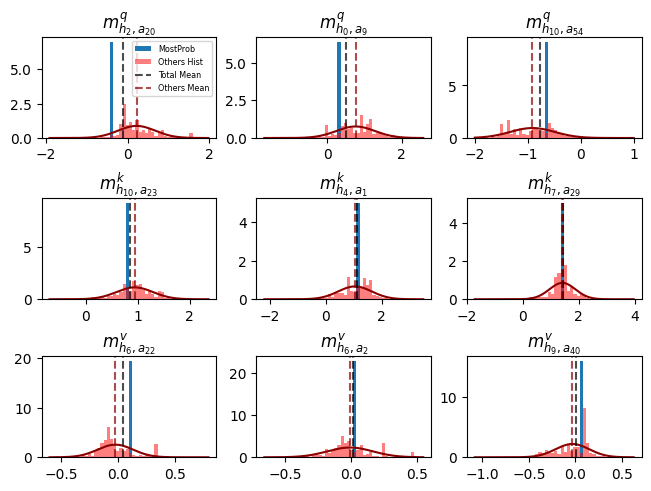

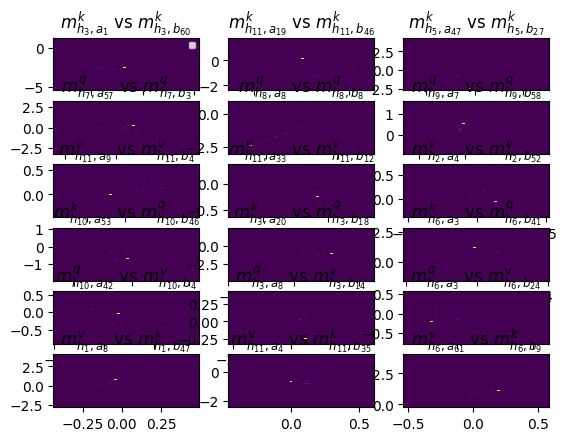

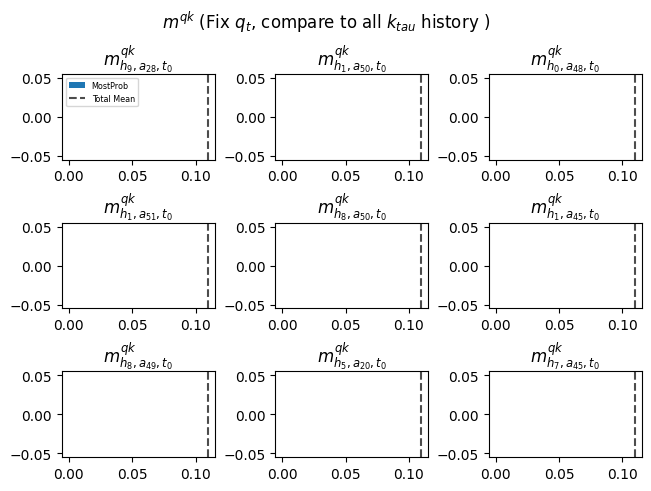

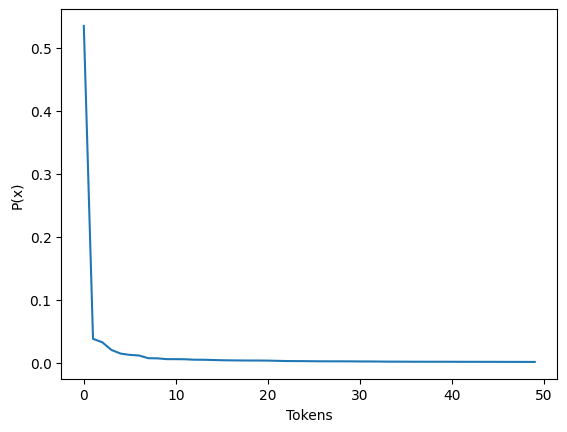

In [17]:
# Select context:
temperature = 0.8

explore_model(start, temperature, top_k)

T = 1

Computing samples  0 to 10000
Computing samples  10000 to 20000
Plot q 2 20 Unique 3783
Plot q 0 9 Unique 3784
Plot q 10 54 Unique 3784
Plot k 10 23 Unique 3784
Plot k 4 1 Unique 3783
Plot k 7 29 Unique 3782
Plot v 6 22 Unique 3784
Plot v 6 2 Unique 3784
Plot v 9 40 Unique 3784
Plot q 9 28 Unique 3784
Plot q 1 50 Unique 3784
Plot q 0 48 Unique 3784
Plot k 1 51 Unique 3784
Plot k 8 50 Unique 3784
Plot k 1 45 Unique 3784
Plot v 8 49 Unique 3784
Plot v 5 20 Unique 3784
Plot v 7 45 Unique 3784


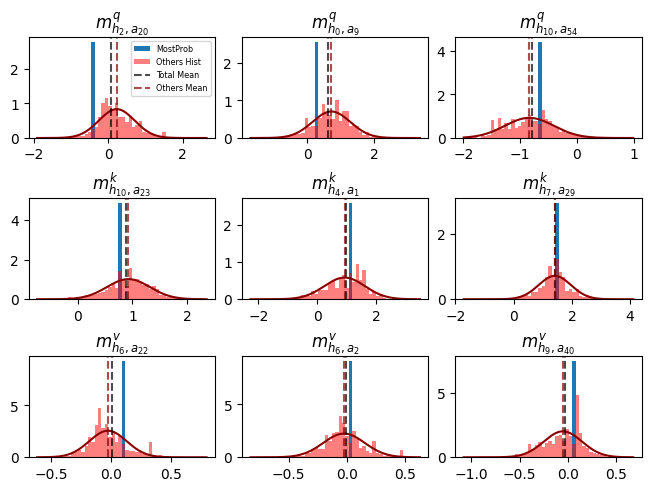

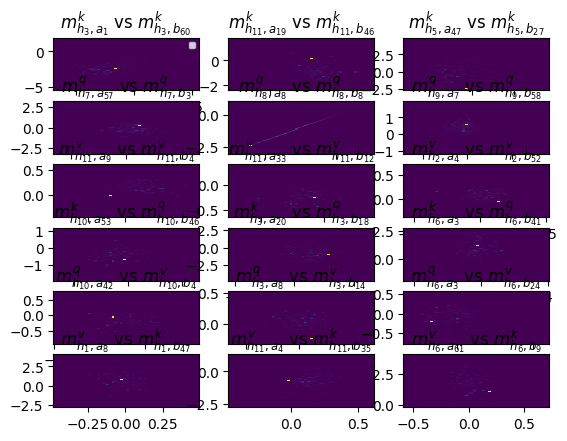

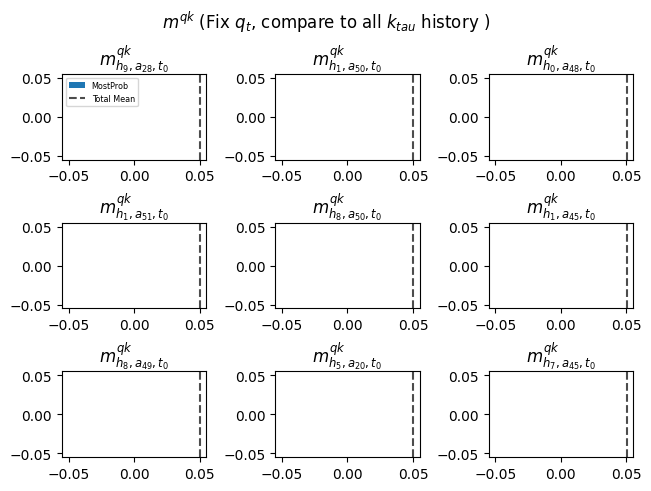

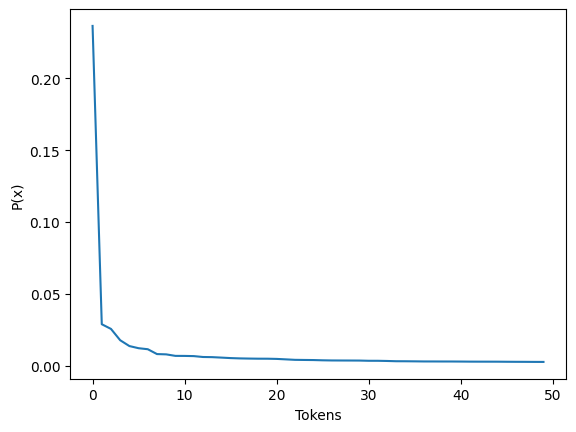

In [18]:

temperature = 1
explore_model(start, temperature, top_k)

T = 1.2

Computing samples  0 to 10000
Computing samples  10000 to 20000
Plot q 2 20 Unique 5872
Plot q 0 9 Unique 5873
Plot q 10 54 Unique 5870
Plot k 10 23 Unique 5870
Plot k 4 1 Unique 5872
Plot k 7 29 Unique 5870
Plot v 6 22 Unique 5873
Plot v 6 2 Unique 5873
Plot v 9 40 Unique 5873
Plot q 9 28 Unique 5873
Plot q 1 50 Unique 5873
Plot q 0 48 Unique 5873
Plot k 1 51 Unique 5873
Plot k 8 50 Unique 5873
Plot k 1 45 Unique 5873
Plot v 8 49 Unique 5873
Plot v 5 20 Unique 5873
Plot v 7 45 Unique 5873


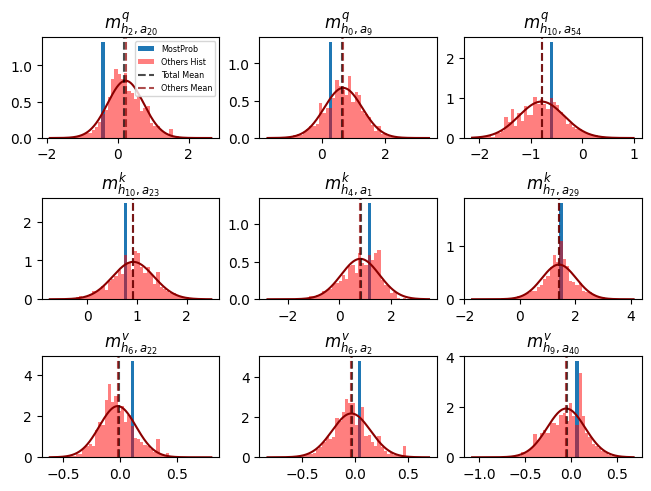

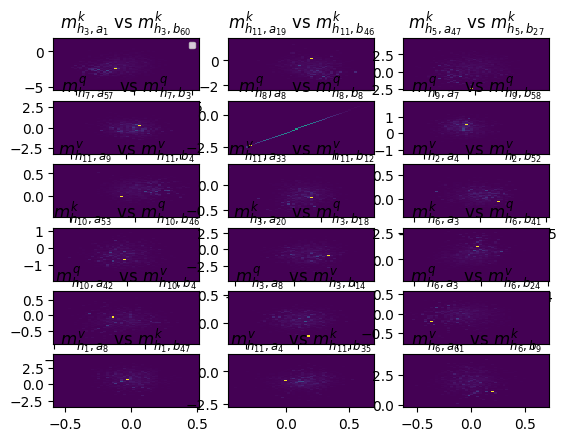

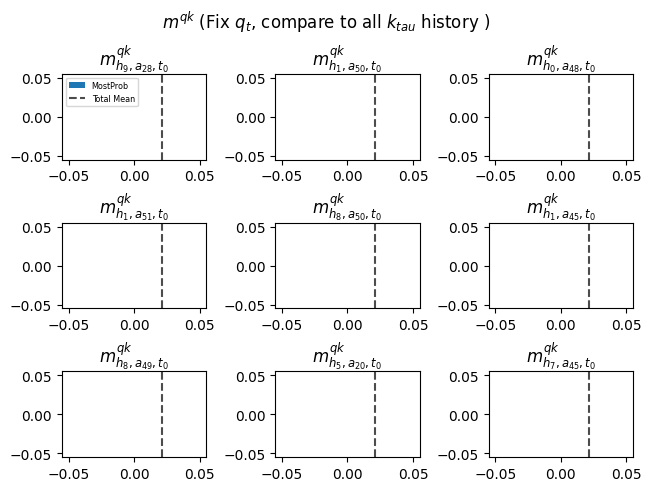

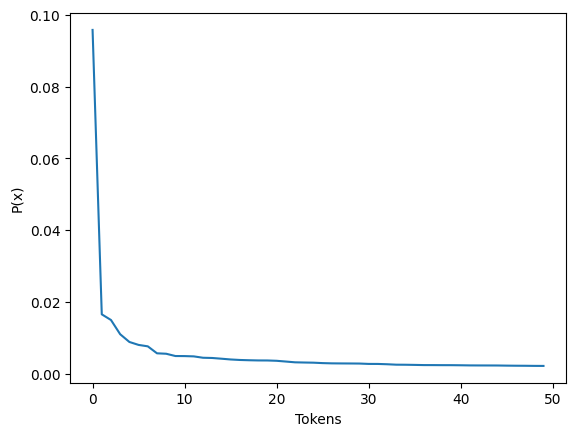

In [19]:
temperature = 1.2

explore_model(start, temperature, top_k)

T = 1.4

Computing samples  0 to 10000
Computing samples  10000 to 20000
Plot q 2 20 Unique 7315
Plot q 0 9 Unique 7316
Plot q 10 54 Unique 7312
Plot k 10 23 Unique 7313
Plot k 4 1 Unique 7315
Plot k 7 29 Unique 7311
Plot v 6 22 Unique 7316
Plot v 6 2 Unique 7316
Plot v 9 40 Unique 7316
Plot q 9 28 Unique 7316
Plot q 1 50 Unique 7316
Plot q 0 48 Unique 7316
Plot k 1 51 Unique 7316
Plot k 8 50 Unique 7316
Plot k 1 45 Unique 7316
Plot v 8 49 Unique 7316
Plot v 5 20 Unique 7316
Plot v 7 45 Unique 7316


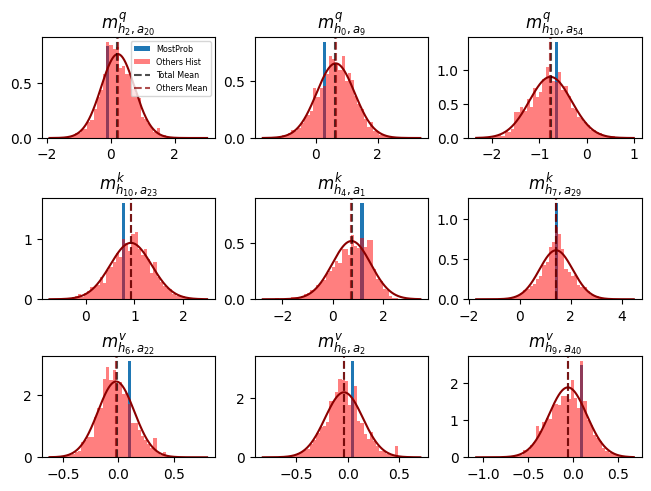

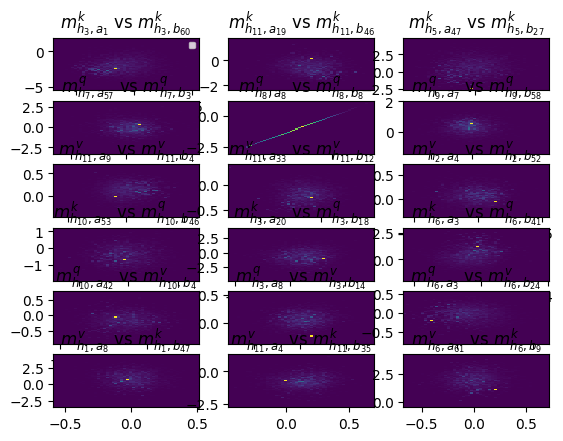

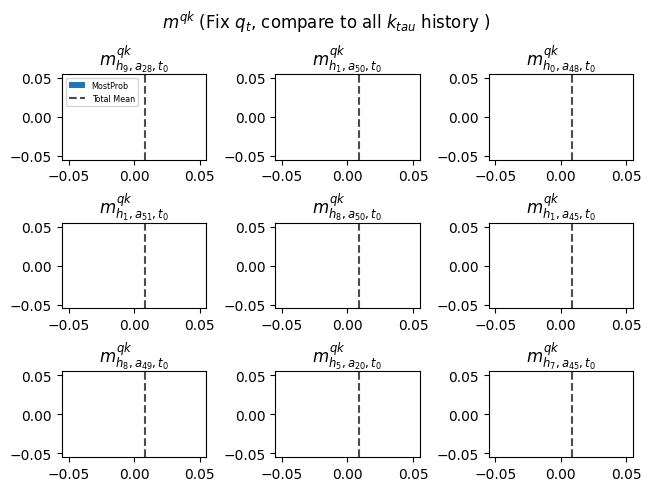

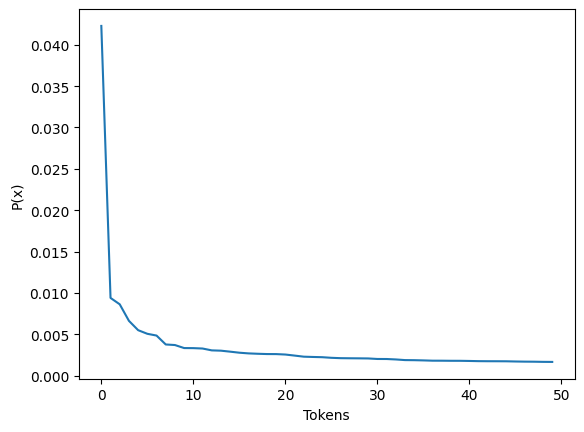

In [20]:
temperature = 1.4

explore_model(start, temperature, top_k)

T = 1.6

Computing samples  0 to 10000
Computing samples  10000 to 20000
Plot q 2 20 Unique 8392
Plot q 0 9 Unique 8393
Plot q 10 54 Unique 8387
Plot k 10 23 Unique 8390
Plot k 4 1 Unique 8392
Plot k 7 29 Unique 8388
Plot v 6 22 Unique 8393
Plot v 6 2 Unique 8393
Plot v 9 40 Unique 8393
Plot q 9 28 Unique 8393
Plot q 1 50 Unique 8393
Plot q 0 48 Unique 8393
Plot k 1 51 Unique 8393
Plot k 8 50 Unique 8393
Plot k 1 45 Unique 8393
Plot v 8 49 Unique 8393
Plot v 5 20 Unique 8393
Plot v 7 45 Unique 8393


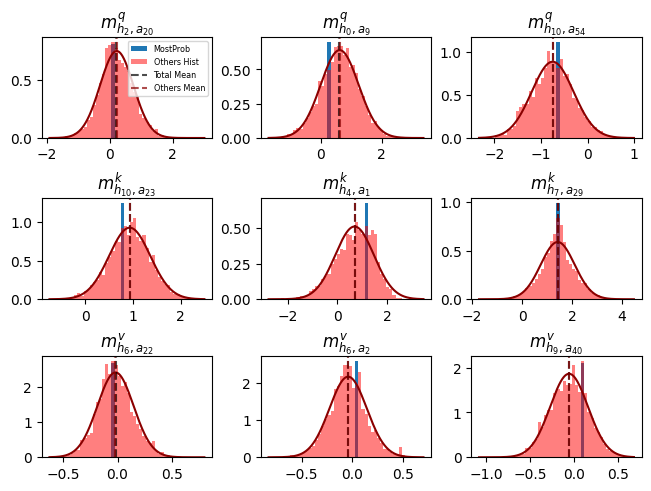

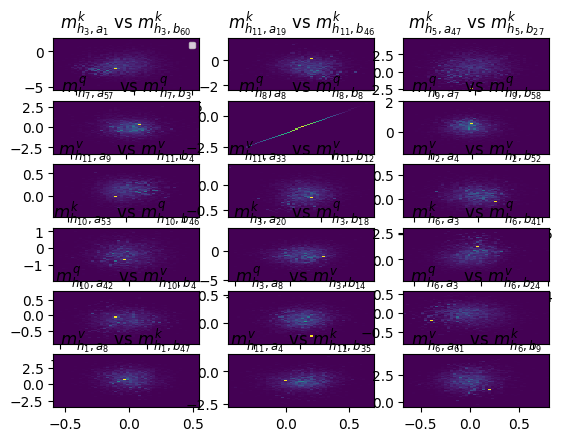

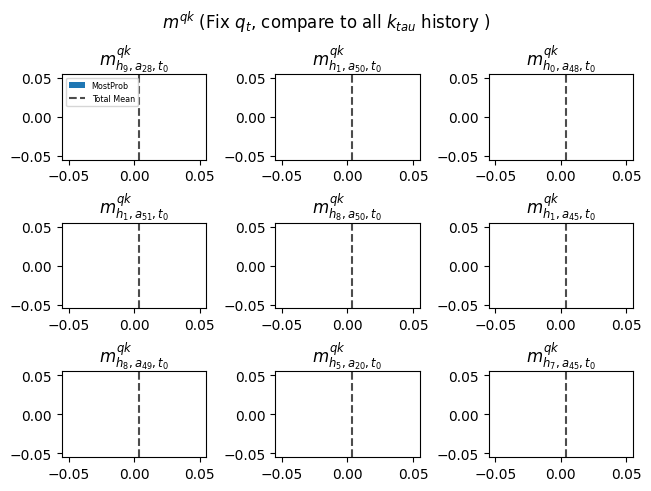

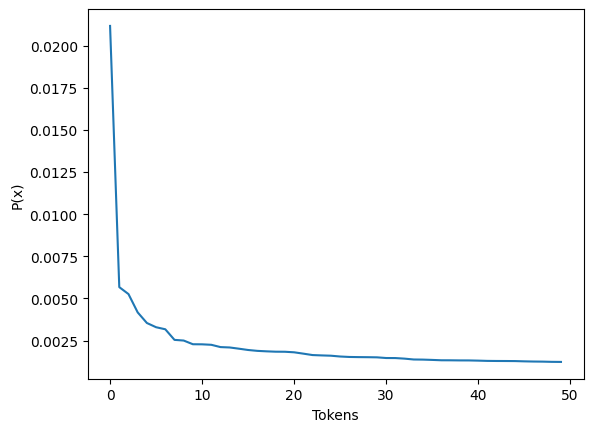

In [21]:
temperature = 1.6

explore_model(start, temperature, top_k)

### Short sentence 1 (from The Lion King article in Wikipedia)

In [22]:
start = "\nThe Lion King was conceived during conversations among various Disney executives, to whom several writers submitted early treatments. Original director George Scribner had envisioned"
top_k = 20000

T = 0.8

Computing samples  0 to 10000
Computing samples  10000 to 20000
Plot q 2 20 Unique 463
Plot q 0 9 Unique 463
Plot q 10 54 Unique 463
Plot k 10 23 Unique 463
Plot k 4 1 Unique 463
Plot k 7 29 Unique 463
Plot v 6 22 Unique 463
Plot v 6 2 Unique 463
Plot v 9 40 Unique 463
Plot q 9 28 Unique 463
Plot q 1 50 Unique 463
Plot q 0 48 Unique 463
Plot k 1 51 Unique 463
Plot k 8 50 Unique 463
Plot k 1 45 Unique 463
Plot v 8 49 Unique 463
Plot v 5 20 Unique 463
Plot v 7 45 Unique 463


<ipython-input-14-a0c830be1693>:198: UserWarning: The figure layout has changed to tight
  fig.tight_layout()


Plot q 10 48 Unique 463
Plot q 8 27 Unique 463
Plot q 8 7 Unique 463
Plot k 9 20 Unique 463
Plot k 6 21 Unique 463
Plot k 2 44 Unique 463
Plot v 7 0 Unique 463
Plot v 0 52 Unique 463
Plot v 2 5 Unique 463


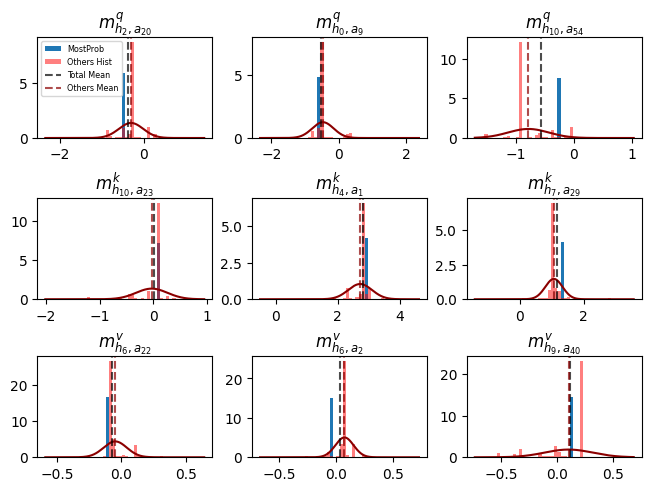

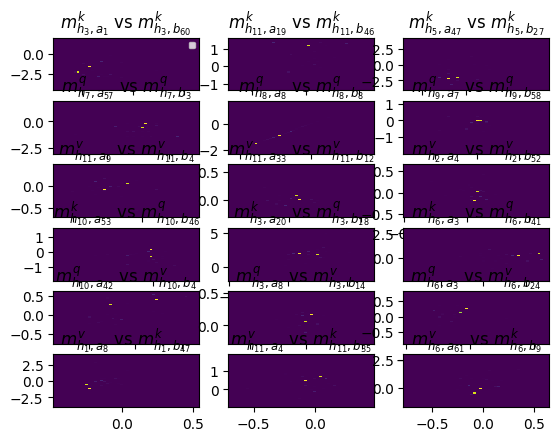

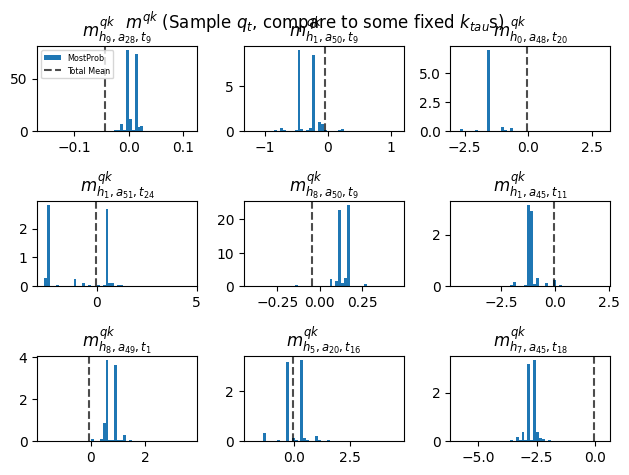

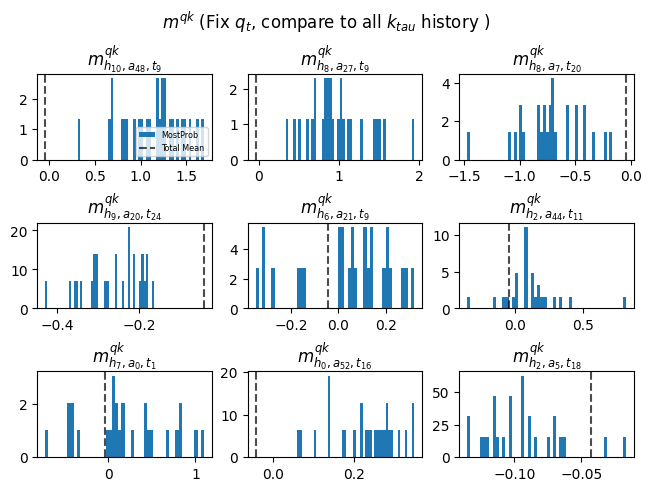

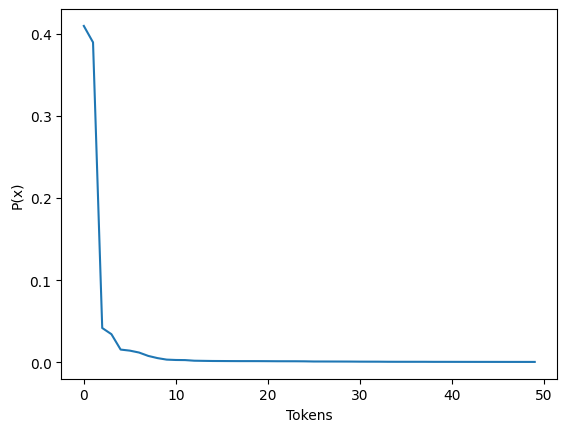

In [23]:
temperature = 0.8
explore_model(start, temperature, top_k)

T = 1

Computing samples  0 to 10000
Computing samples  10000 to 20000
Plot q 2 20 Unique 1804
Plot q 0 9 Unique 1804
Plot q 10 54 Unique 1804
Plot k 10 23 Unique 1804
Plot k 4 1 Unique 1804
Plot k 7 29 Unique 1804
Plot v 6 22 Unique 1804
Plot v 6 2 Unique 1804
Plot v 9 40 Unique 1804
Plot q 9 28 Unique 1804
Plot q 1 50 Unique 1804
Plot q 0 48 Unique 1804
Plot k 1 51 Unique 1804
Plot k 8 50 Unique 1804
Plot k 1 45 Unique 1804
Plot v 8 49 Unique 1804
Plot v 5 20 Unique 1804
Plot v 7 45 Unique 1804


<ipython-input-14-a0c830be1693>:198: UserWarning: The figure layout has changed to tight
  fig.tight_layout()


Plot q 10 48 Unique 1804
Plot q 8 27 Unique 1804
Plot q 8 7 Unique 1804
Plot k 9 20 Unique 1804
Plot k 6 21 Unique 1804
Plot k 2 44 Unique 1804
Plot v 7 0 Unique 1804
Plot v 0 52 Unique 1804
Plot v 2 5 Unique 1804


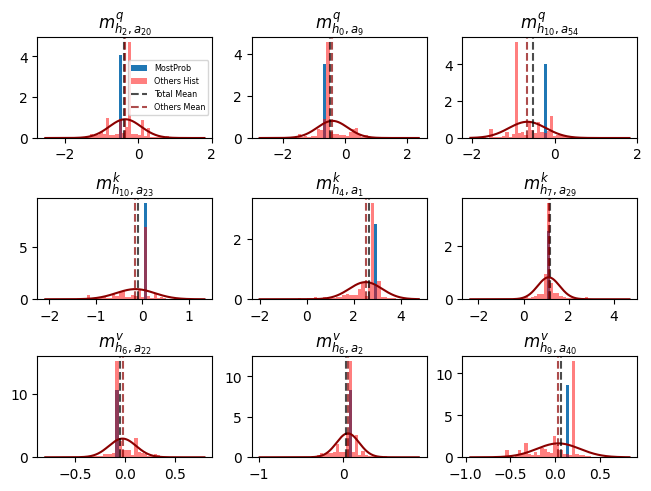

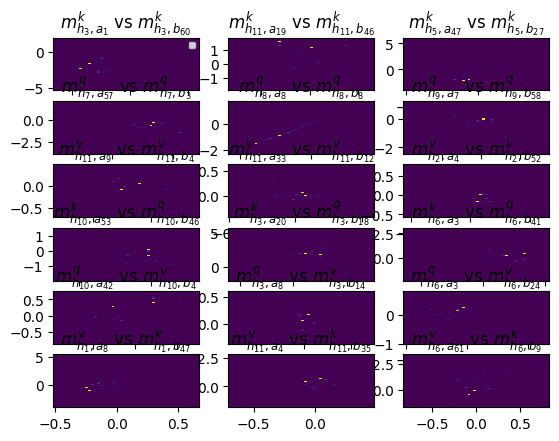

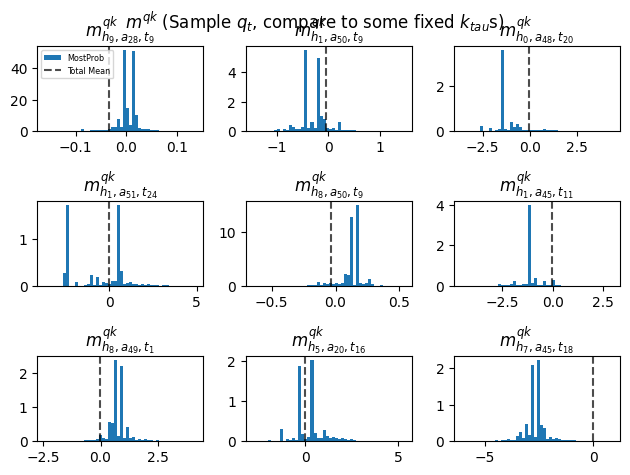

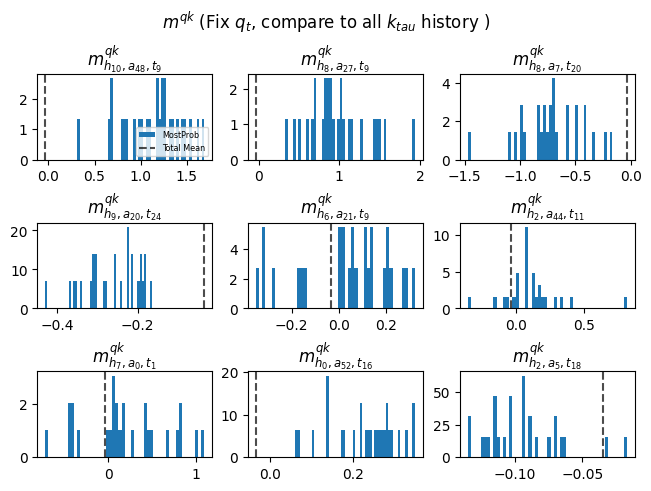

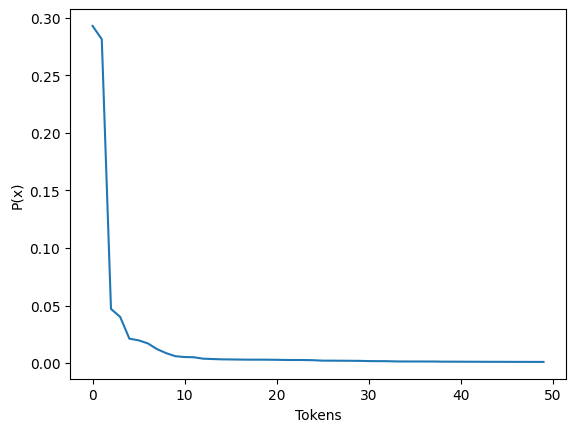

In [24]:
temperature = 1
explore_model(start, temperature, top_k)

T = 1.2

Computing samples  0 to 10000
Computing samples  10000 to 20000
Plot q 2 20 Unique 3909
Plot q 0 9 Unique 3909
Plot q 10 54 Unique 3909
Plot k 10 23 Unique 3909
Plot k 4 1 Unique 3908
Plot k 7 29 Unique 3909
Plot v 6 22 Unique 3909
Plot v 6 2 Unique 3909
Plot v 9 40 Unique 3909
Plot q 9 28 Unique 3909
Plot q 1 50 Unique 3909
Plot q 0 48 Unique 3909
Plot k 1 51 Unique 3909
Plot k 8 50 Unique 3909
Plot k 1 45 Unique 3909
Plot v 8 49 Unique 3909
Plot v 5 20 Unique 3909
Plot v 7 45 Unique 3909


<ipython-input-14-a0c830be1693>:198: UserWarning: The figure layout has changed to tight
  fig.tight_layout()


Plot q 10 48 Unique 3909
Plot q 8 27 Unique 3909
Plot q 8 7 Unique 3909
Plot k 9 20 Unique 3909
Plot k 6 21 Unique 3909
Plot k 2 44 Unique 3909
Plot v 7 0 Unique 3909
Plot v 0 52 Unique 3909
Plot v 2 5 Unique 3909


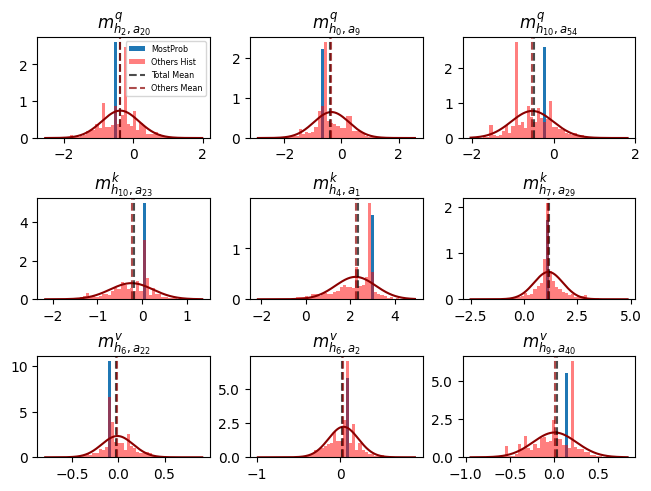

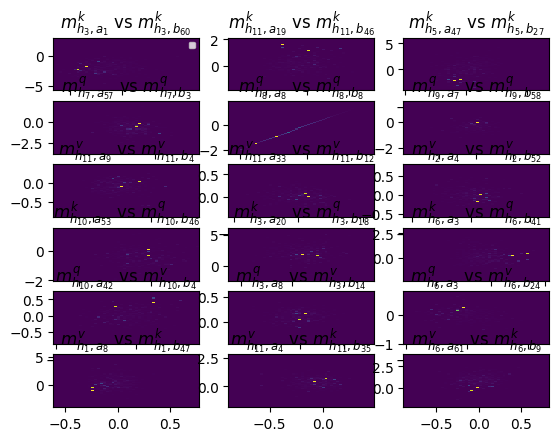

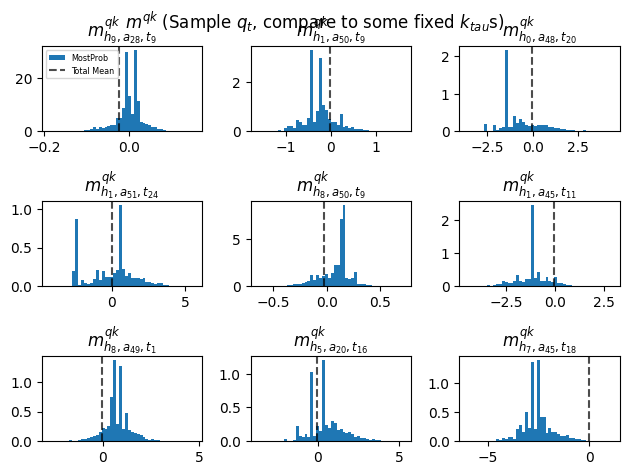

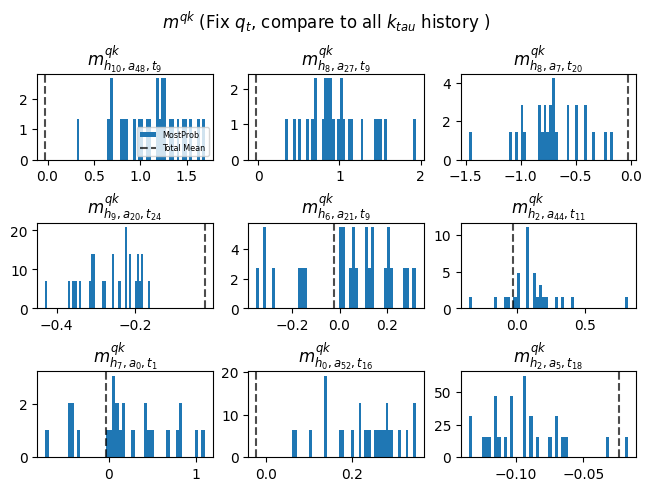

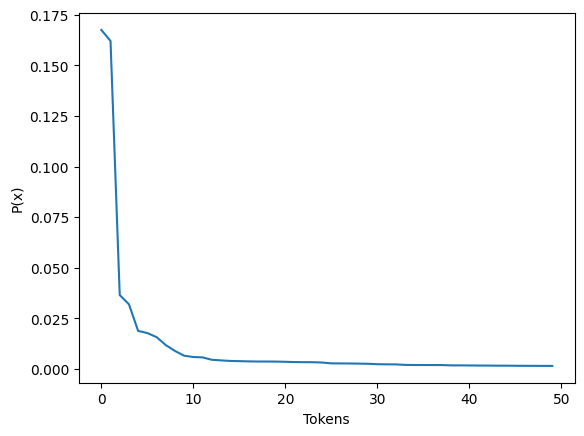

In [25]:
temperature = 1.2
explore_model(start, temperature, top_k)

T = 1.4

Computing samples  0 to 10000
Computing samples  10000 to 20000
Plot q 2 20 Unique 5966
Plot q 0 9 Unique 5966
Plot q 10 54 Unique 5966
Plot k 10 23 Unique 5966
Plot k 4 1 Unique 5963
Plot k 7 29 Unique 5966
Plot v 6 22 Unique 5966
Plot v 6 2 Unique 5966
Plot v 9 40 Unique 5966
Plot q 9 28 Unique 5966
Plot q 1 50 Unique 5966
Plot q 0 48 Unique 5966
Plot k 1 51 Unique 5966
Plot k 8 50 Unique 5966
Plot k 1 45 Unique 5966
Plot v 8 49 Unique 5966
Plot v 5 20 Unique 5966
Plot v 7 45 Unique 5966


<ipython-input-14-a0c830be1693>:198: UserWarning: The figure layout has changed to tight
  fig.tight_layout()


Plot q 10 48 Unique 5966
Plot q 8 27 Unique 5966
Plot q 8 7 Unique 5966
Plot k 9 20 Unique 5966
Plot k 6 21 Unique 5966
Plot k 2 44 Unique 5966
Plot v 7 0 Unique 5966
Plot v 0 52 Unique 5966
Plot v 2 5 Unique 5966


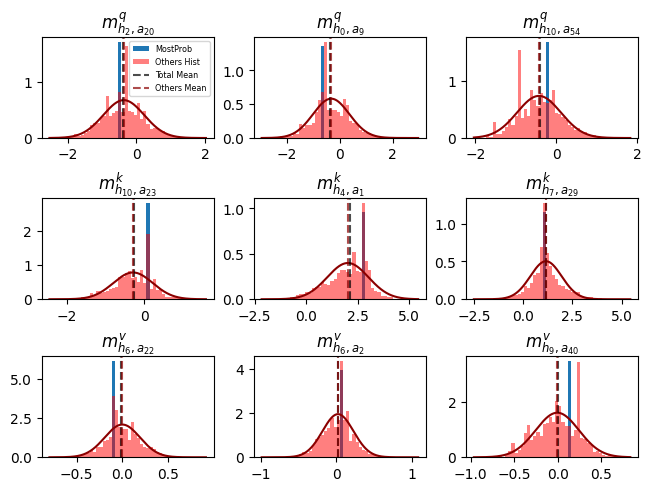

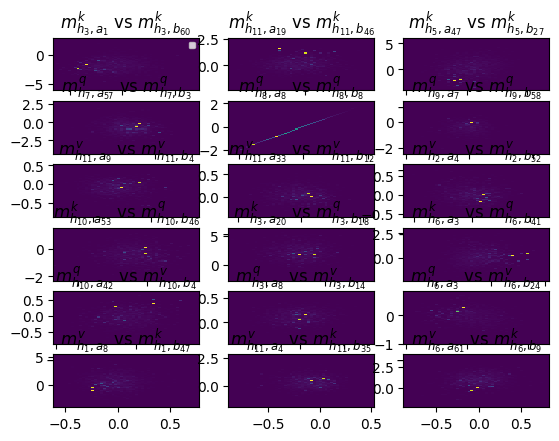

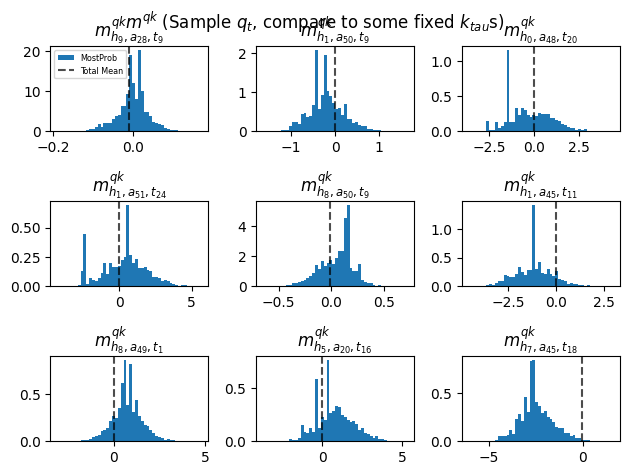

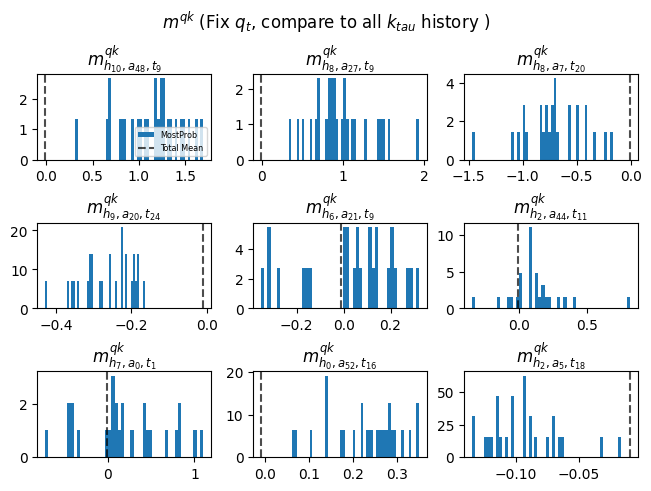

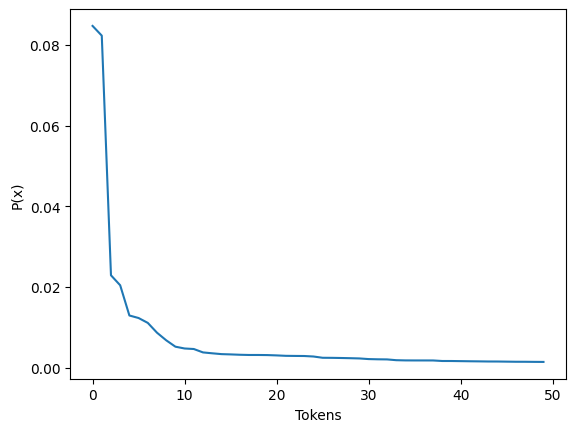

In [26]:
temperature = 1.4
explore_model(start, temperature, top_k)

T = 1.6

Computing samples  0 to 10000
Computing samples  10000 to 20000
Plot q 2 20 Unique 7494
Plot q 0 9 Unique 7494
Plot q 10 54 Unique 7494
Plot k 10 23 Unique 7494
Plot k 4 1 Unique 7490
Plot k 7 29 Unique 7493
Plot v 6 22 Unique 7494
Plot v 6 2 Unique 7494
Plot v 9 40 Unique 7494
Plot q 9 28 Unique 7494
Plot q 1 50 Unique 7494
Plot q 0 48 Unique 7494
Plot k 1 51 Unique 7494
Plot k 8 50 Unique 7494
Plot k 1 45 Unique 7494
Plot v 8 49 Unique 7494
Plot v 5 20 Unique 7494
Plot v 7 45 Unique 7494


<ipython-input-14-a0c830be1693>:198: UserWarning: The figure layout has changed to tight
  fig.tight_layout()


Plot q 10 48 Unique 7494
Plot q 8 27 Unique 7494
Plot q 8 7 Unique 7494
Plot k 9 20 Unique 7494
Plot k 6 21 Unique 7494
Plot k 2 44 Unique 7494
Plot v 7 0 Unique 7494
Plot v 0 52 Unique 7494
Plot v 2 5 Unique 7494


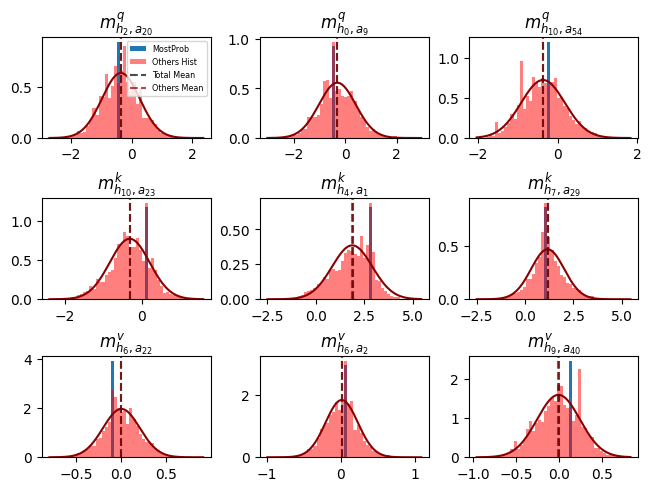

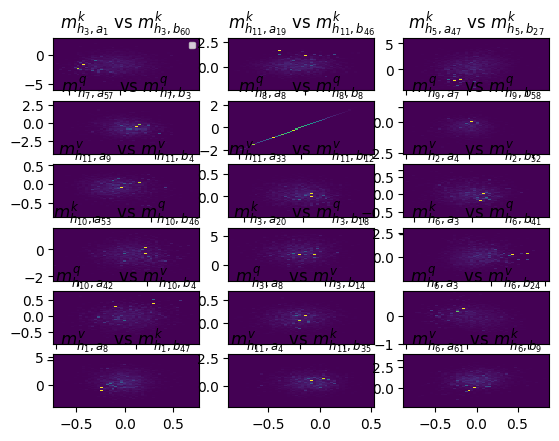

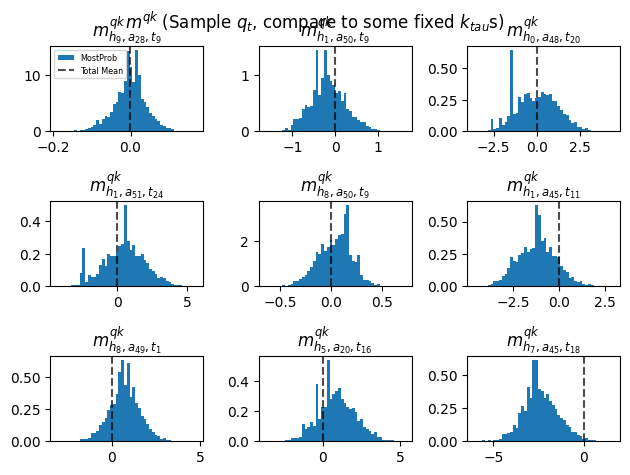

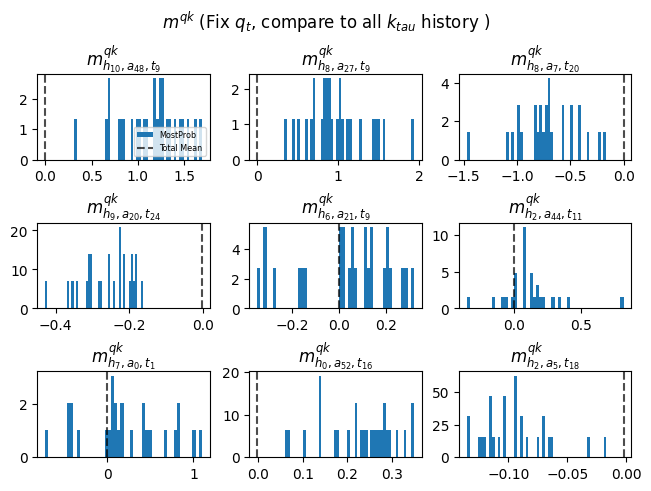

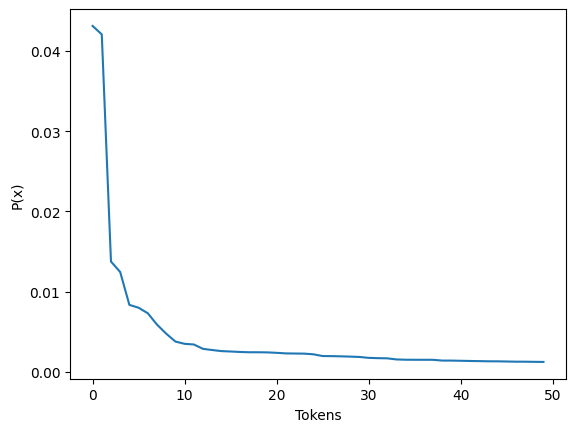

In [27]:
temperature = 1.6
explore_model(start, temperature, top_k)

### Short sentence 1 (cropped before)

In [28]:
start = "\nThe Lion King was conceived during"
top_k = 20000

T = 0.8

Computing samples  0 to 10000
Computing samples  10000 to 20000
Plot q 2 20 Unique 576
Plot q 0 9 Unique 576
Plot q 10 54 Unique 576
Plot k 10 23 Unique 576
Plot k 4 1 Unique 576
Plot k 7 29 Unique 576
Plot v 6 22 Unique 576
Plot v 6 2 Unique 576
Plot v 9 40 Unique 576
Plot q 9 28 Unique 576
Plot q 1 50 Unique 576
Plot q 0 48 Unique 576
Plot k 1 51 Unique 576
Plot k 8 50 Unique 576
Plot k 1 45 Unique 576
Plot v 8 49 Unique 576
Plot v 5 20 Unique 576
Plot v 7 45 Unique 576


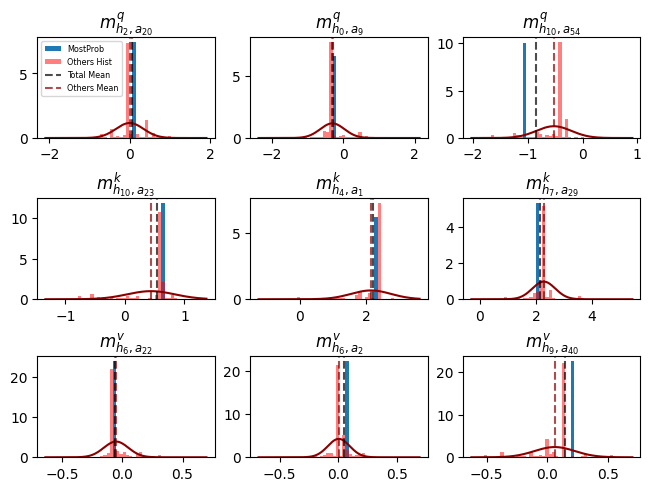

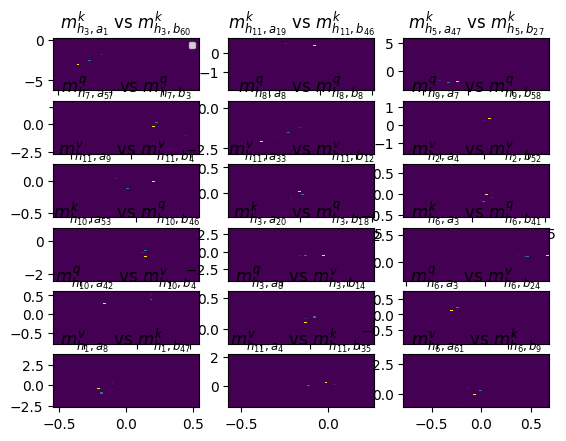

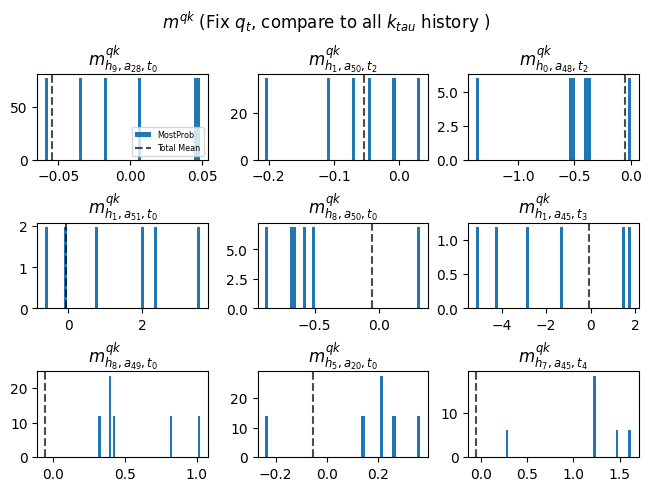

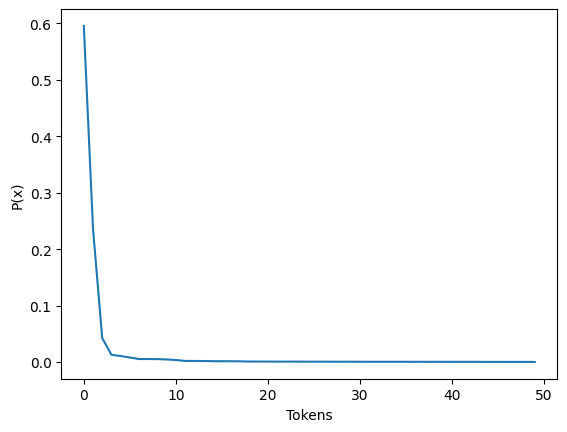

In [29]:
# Select context:
temperature = 0.8
explore_model(start, temperature, top_k)

T = 1

Computing samples  0 to 10000
Computing samples  10000 to 20000
Plot q 2 20 Unique 2165
Plot q 0 9 Unique 2165
Plot q 10 54 Unique 2165
Plot k 10 23 Unique 2165
Plot k 4 1 Unique 2165
Plot k 7 29 Unique 2164
Plot v 6 22 Unique 2165
Plot v 6 2 Unique 2165
Plot v 9 40 Unique 2165
Plot q 9 28 Unique 2165
Plot q 1 50 Unique 2165
Plot q 0 48 Unique 2165
Plot k 1 51 Unique 2165
Plot k 8 50 Unique 2165
Plot k 1 45 Unique 2165
Plot v 8 49 Unique 2165
Plot v 5 20 Unique 2165
Plot v 7 45 Unique 2165


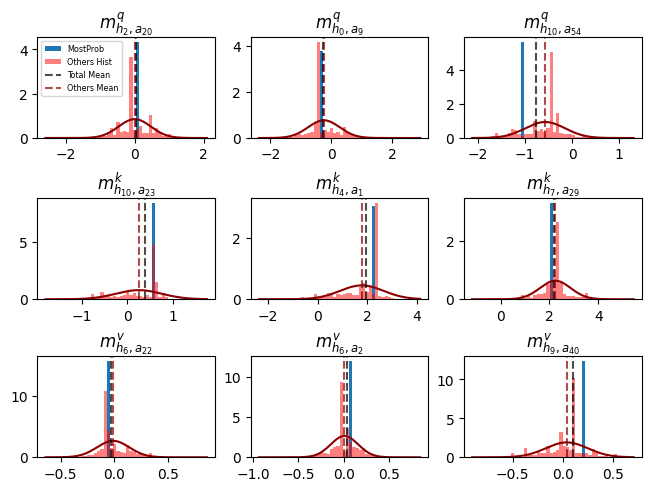

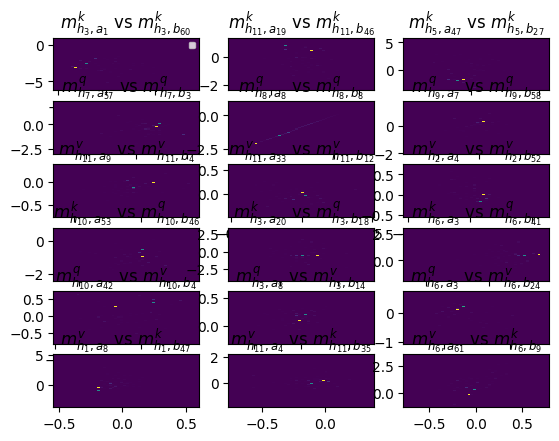

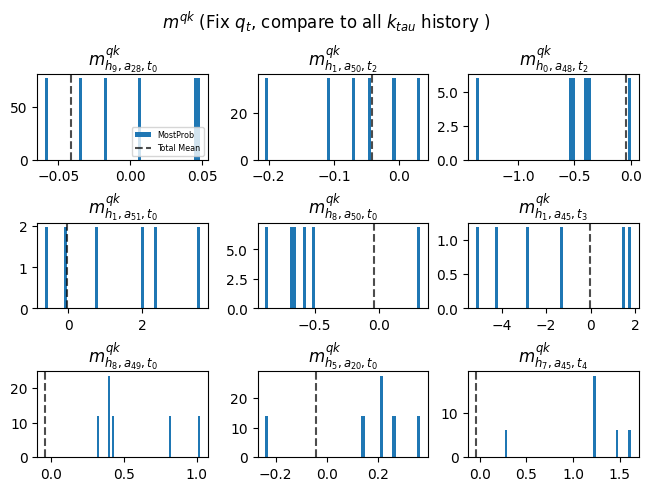

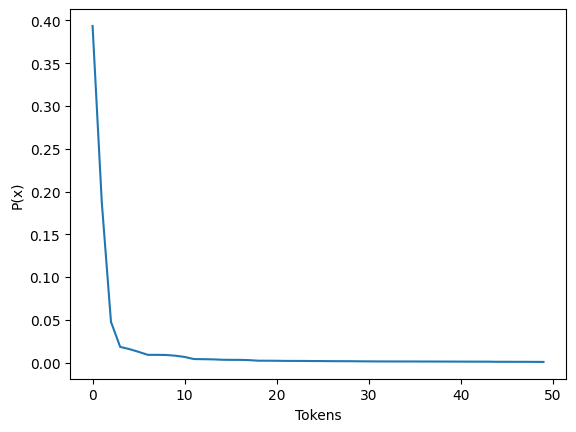

In [30]:
# Select context:
temperature = 1
explore_model(start, temperature, top_k)

T = 1.2

Computing samples  0 to 10000
Computing samples  10000 to 20000
Plot q 2 20 Unique 4261
Plot q 0 9 Unique 4261
Plot q 10 54 Unique 4261
Plot k 10 23 Unique 4261
Plot k 4 1 Unique 4261
Plot k 7 29 Unique 4260
Plot v 6 22 Unique 4261
Plot v 6 2 Unique 4261
Plot v 9 40 Unique 4261
Plot q 9 28 Unique 4261
Plot q 1 50 Unique 4261
Plot q 0 48 Unique 4261
Plot k 1 51 Unique 4261
Plot k 8 50 Unique 4261
Plot k 1 45 Unique 4261
Plot v 8 49 Unique 4261
Plot v 5 20 Unique 4261
Plot v 7 45 Unique 4261


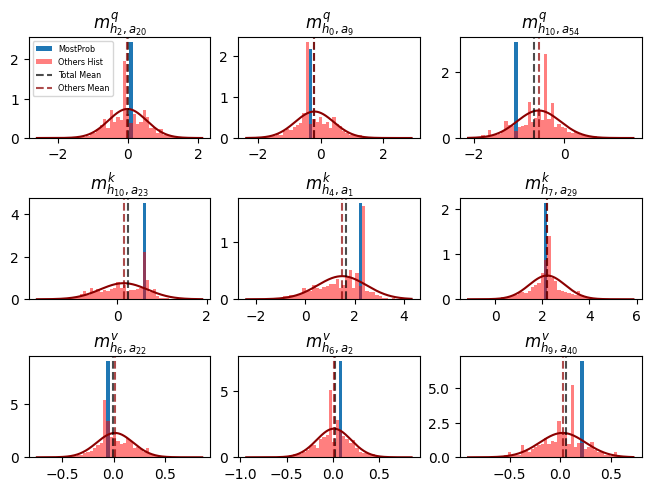

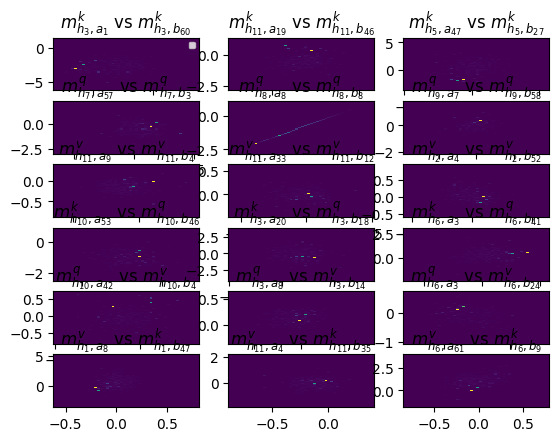

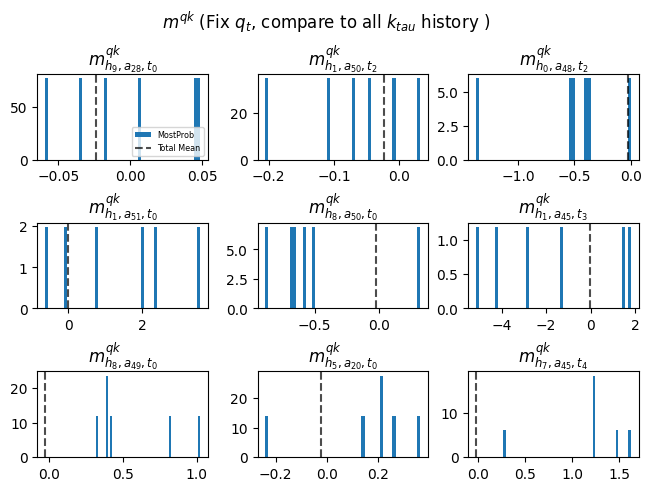

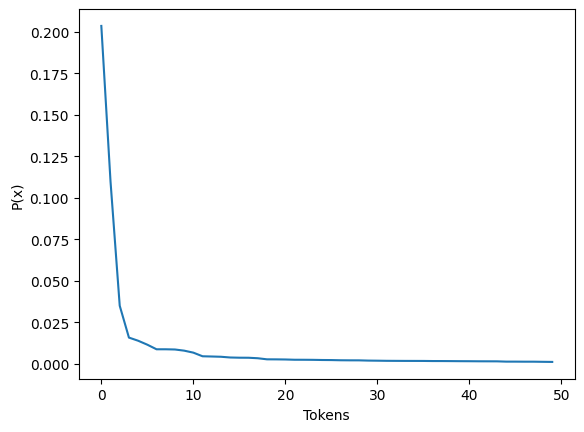

In [31]:
temperature = 1.2
explore_model(start, temperature, top_k)

T = 1.4

Computing samples  0 to 10000
Computing samples  10000 to 20000
Plot q 2 20 Unique 6178
Plot q 0 9 Unique 6178
Plot q 10 54 Unique 6178
Plot k 10 23 Unique 6178
Plot k 4 1 Unique 6178
Plot k 7 29 Unique 6176
Plot v 6 22 Unique 6178
Plot v 6 2 Unique 6178
Plot v 9 40 Unique 6178
Plot q 9 28 Unique 6178
Plot q 1 50 Unique 6178
Plot q 0 48 Unique 6178
Plot k 1 51 Unique 6178
Plot k 8 50 Unique 6178
Plot k 1 45 Unique 6178
Plot v 8 49 Unique 6178
Plot v 5 20 Unique 6178
Plot v 7 45 Unique 6178


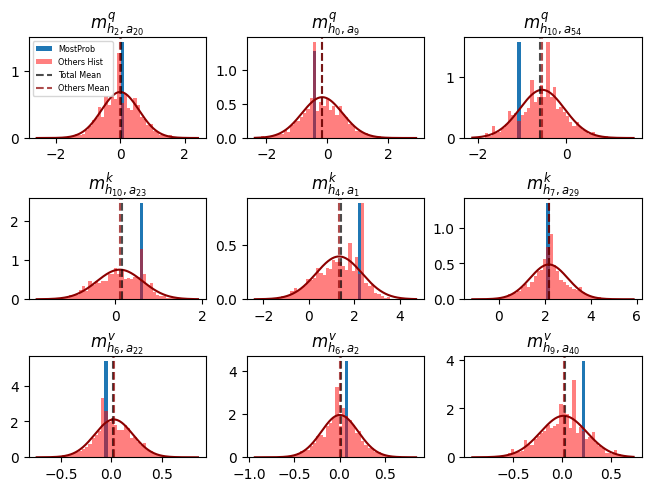

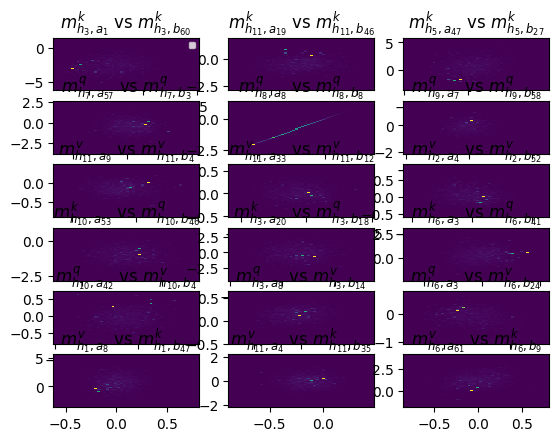

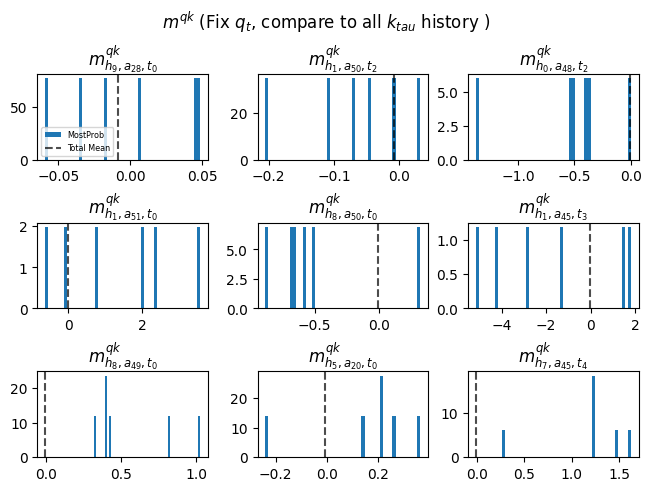

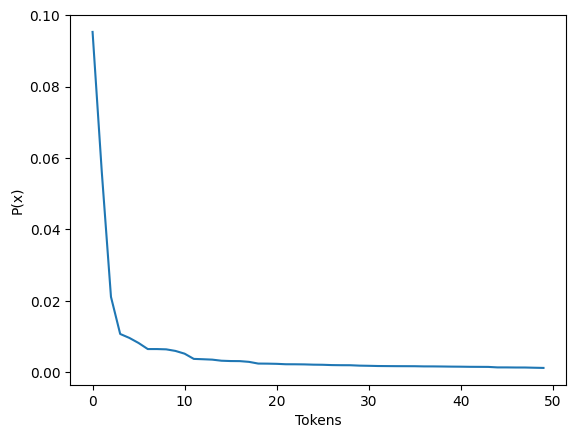

In [32]:
temperature = 1.4
explore_model(start, temperature, top_k)

T = 1.6

Computing samples  0 to 10000
Computing samples  10000 to 20000
Plot q 2 20 Unique 7631
Plot q 0 9 Unique 7631
Plot q 10 54 Unique 7631
Plot k 10 23 Unique 7631
Plot k 4 1 Unique 7631
Plot k 7 29 Unique 7629
Plot v 6 22 Unique 7631
Plot v 6 2 Unique 7631
Plot v 9 40 Unique 7631
Plot q 9 28 Unique 7631
Plot q 1 50 Unique 7631
Plot q 0 48 Unique 7631
Plot k 1 51 Unique 7631
Plot k 8 50 Unique 7631
Plot k 1 45 Unique 7631
Plot v 8 49 Unique 7631
Plot v 5 20 Unique 7631
Plot v 7 45 Unique 7631


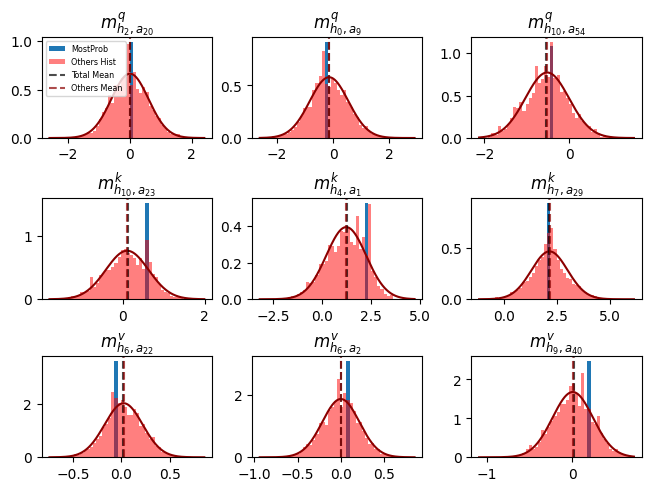

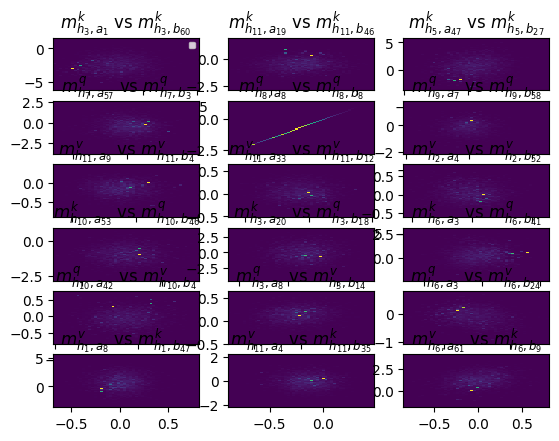

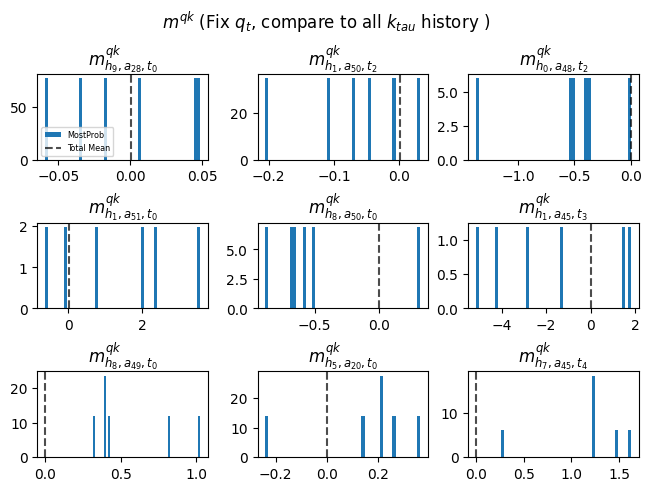

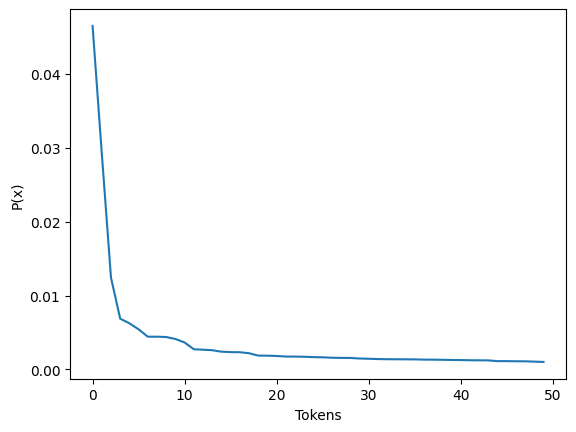

In [33]:
temperature = 1.6
explore_model(start, temperature, top_k)

### Short sentence 2 (from the Neuroscience article in Wikipedia)

In [34]:
start = "\nNeuroscience is the scientific study of the nervous system (the brain, spinal cord, and peripheral nervous system), its functions, and its disorders. It is a multidisciplinary science that combines"
top_k = 20000

T = 0.8

Computing samples  0 to 10000
Computing samples  10000 to 20000
Plot q 2 20 Unique 885
Plot q 0 9 Unique 885
Plot q 10 54 Unique 885
Plot k 10 23 Unique 885
Plot k 4 1 Unique 885
Plot k 7 29 Unique 885
Plot v 6 22 Unique 885
Plot v 6 2 Unique 885
Plot v 9 40 Unique 885
Plot q 9 28 Unique 885
Plot q 1 50 Unique 885
Plot q 0 48 Unique 885
Plot k 1 51 Unique 885
Plot k 8 50 Unique 885
Plot k 1 45 Unique 885
Plot v 8 49 Unique 885
Plot v 5 20 Unique 885
Plot v 7 45 Unique 885


<ipython-input-14-a0c830be1693>:198: UserWarning: The figure layout has changed to tight
  fig.tight_layout()


Plot q 10 48 Unique 885
Plot q 8 27 Unique 885
Plot q 8 7 Unique 885
Plot k 9 20 Unique 885
Plot k 6 21 Unique 885
Plot k 2 44 Unique 885
Plot v 7 0 Unique 885
Plot v 0 52 Unique 885
Plot v 2 5 Unique 885


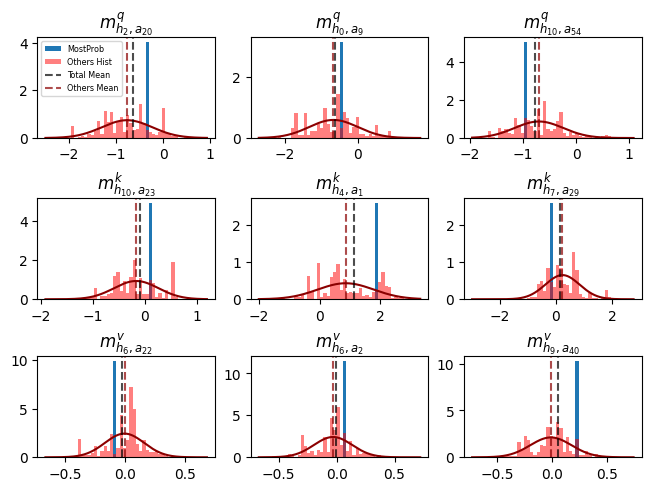

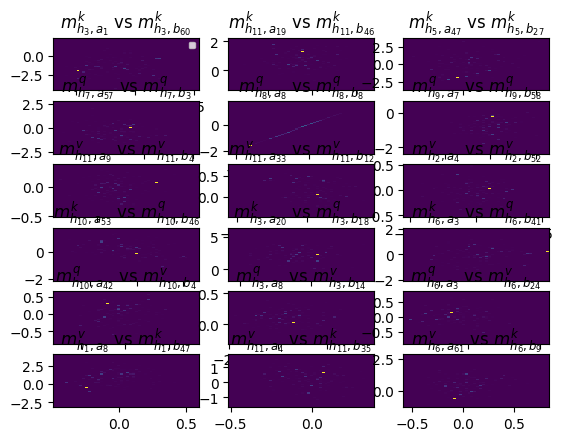

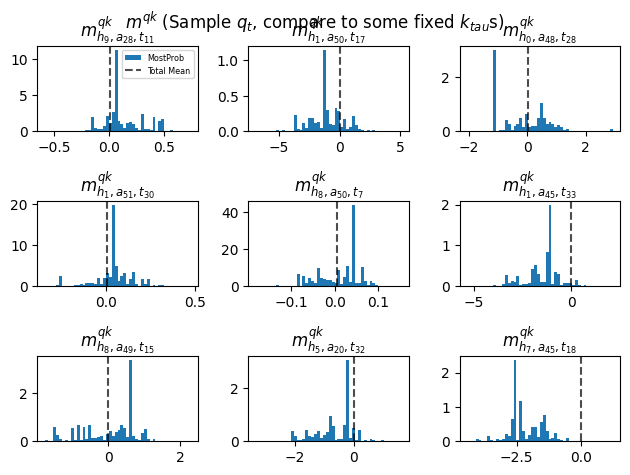

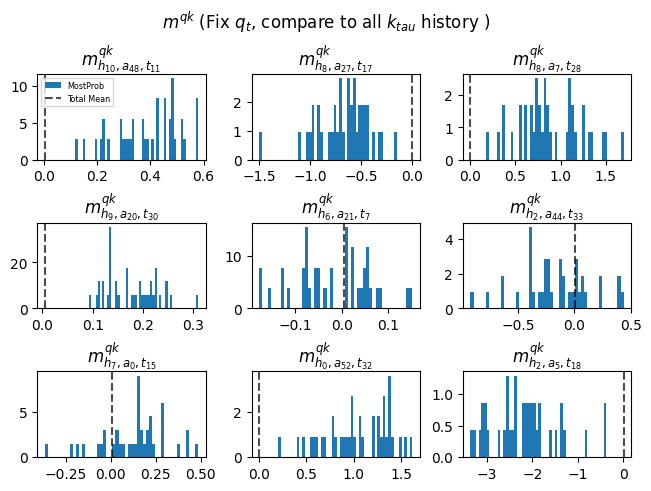

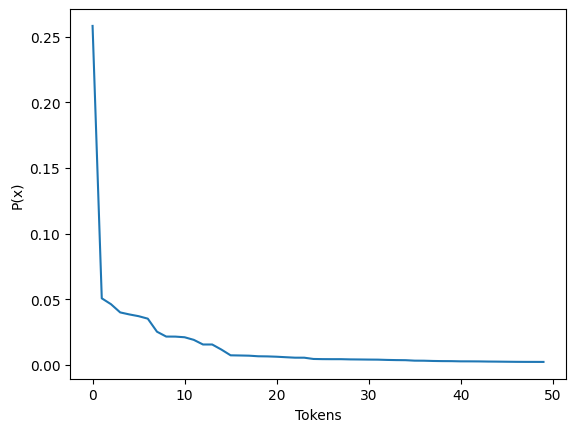

In [35]:
temperature = 0.8
explore_model(start, temperature, top_k)

T = 1

Computing samples  0 to 10000
Computing samples  10000 to 20000
Plot q 2 20 Unique 3783
Plot q 0 9 Unique 3784
Plot q 10 54 Unique 3784
Plot k 10 23 Unique 3784
Plot k 4 1 Unique 3783
Plot k 7 29 Unique 3782
Plot v 6 22 Unique 3784
Plot v 6 2 Unique 3784
Plot v 9 40 Unique 3784


<ipython-input-28-a0c830be1693>:217: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3637.)
  mq_h_i_a = torch.matmul(Wq_h[h_i, feat_a], x_t.T).cpu()


Plot q 9 28 Unique 3784
Plot q 1 50 Unique 3784
Plot q 0 48 Unique 3784
Plot k 1 51 Unique 3784
Plot k 8 50 Unique 3784
Plot k 1 45 Unique 3784
Plot v 8 49 Unique 3784
Plot v 5 20 Unique 3784
Plot v 7 45 Unique 3784


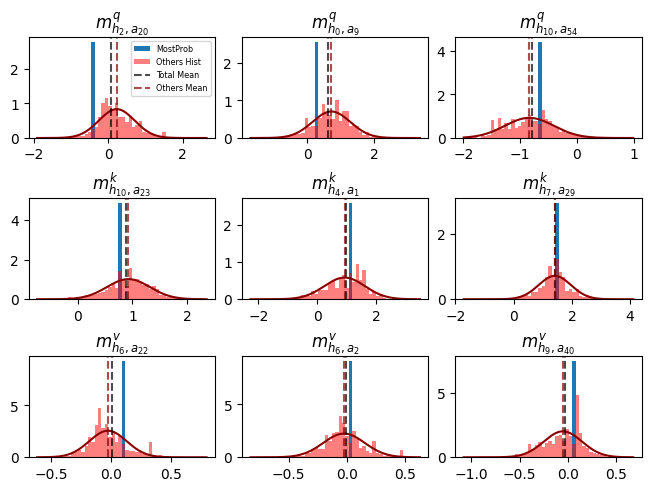

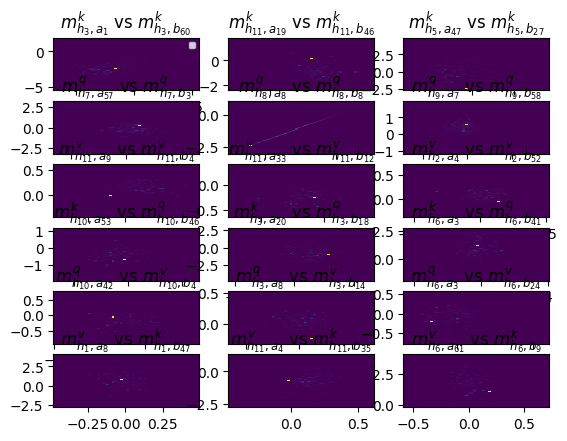

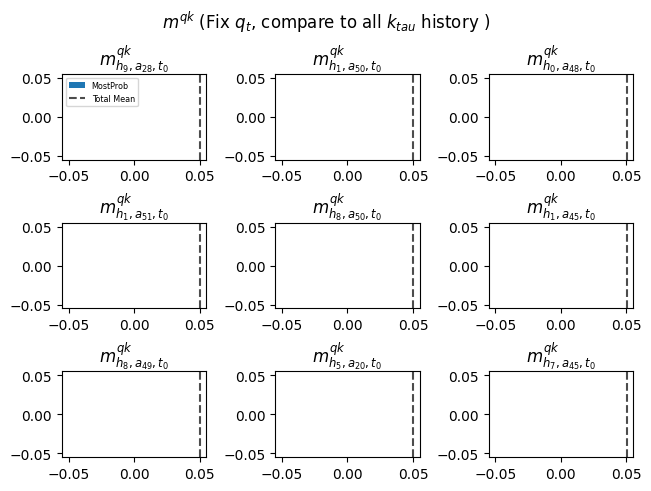

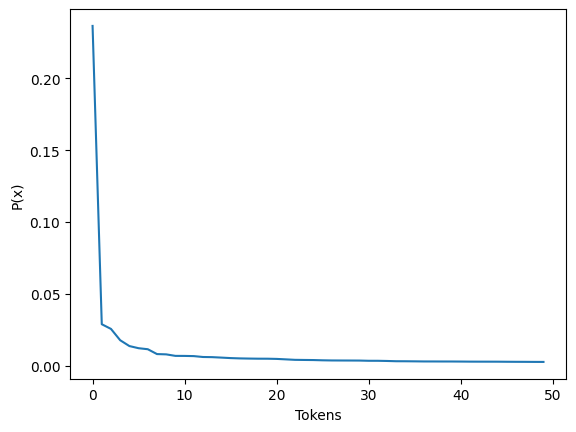

In [32]:
temperature = 1
explore_model(start, temperature, top_k)

T = 1.2

Computing samples  0 to 10000
Computing samples  10000 to 20000
Plot q 2 20 Unique 5872
Plot q 0 9 Unique 5873
Plot q 10 54 Unique 5870
Plot k 10 23 Unique 5870
Plot k 4 1 Unique 5872
Plot k 7 29 Unique 5870
Plot v 6 22 Unique 5873
Plot v 6 2 Unique 5873
Plot v 9 40 Unique 5873
Plot q 9 28 Unique 5873
Plot q 1 50 Unique 5873
Plot q 0 48 Unique 5873
Plot k 1 51 Unique 5873
Plot k 8 50 Unique 5873
Plot k 1 45 Unique 5873
Plot v 8 49 Unique 5873
Plot v 5 20 Unique 5873
Plot v 7 45 Unique 5873


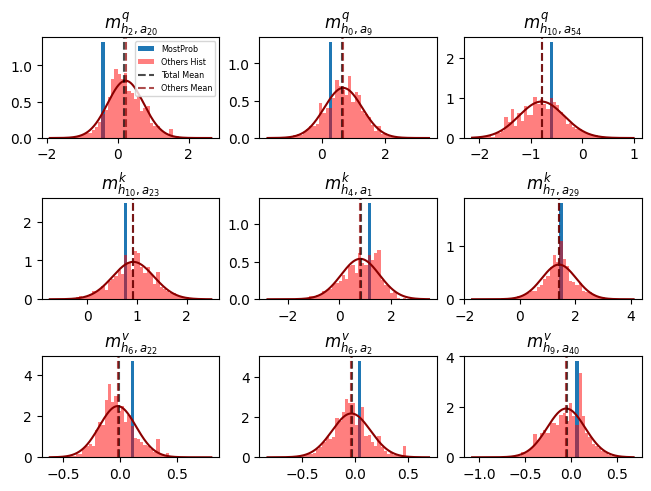

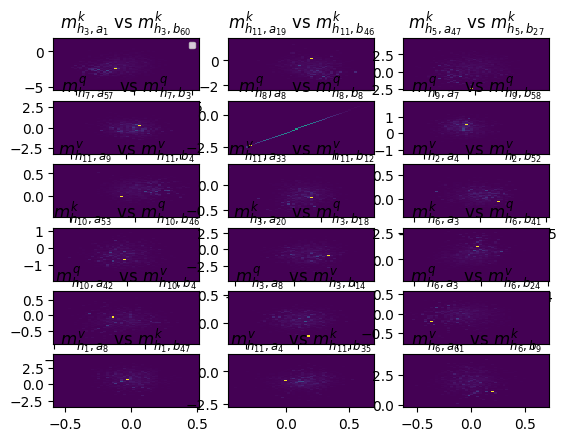

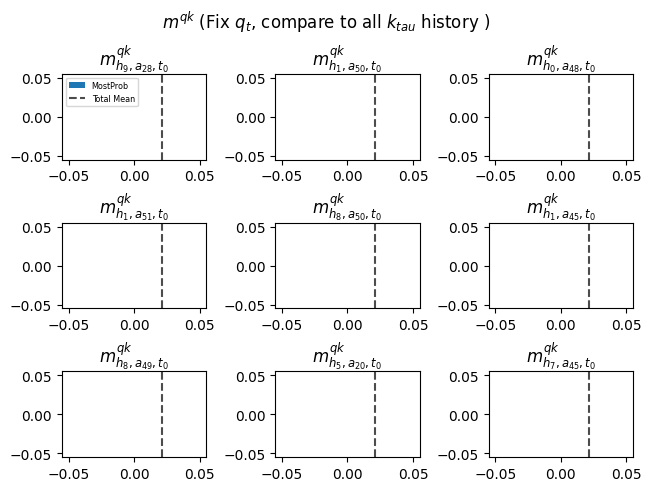

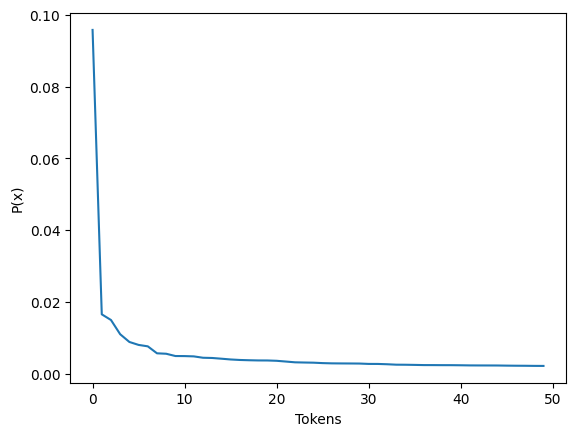

In [33]:
temperature = 1.2
explore_model(start, temperature, top_k)

T = 1.4

Computing samples  0 to 10000
Computing samples  10000 to 20000
Plot q 2 20 Unique 7315
Plot q 0 9 Unique 7316
Plot q 10 54 Unique 7312
Plot k 10 23 Unique 7313
Plot k 4 1 Unique 7315
Plot k 7 29 Unique 7311
Plot v 6 22 Unique 7316
Plot v 6 2 Unique 7316
Plot v 9 40 Unique 7316
Plot q 9 28 Unique 7316
Plot q 1 50 Unique 7316
Plot q 0 48 Unique 7316
Plot k 1 51 Unique 7316
Plot k 8 50 Unique 7316
Plot k 1 45 Unique 7316
Plot v 8 49 Unique 7316
Plot v 5 20 Unique 7316
Plot v 7 45 Unique 7316


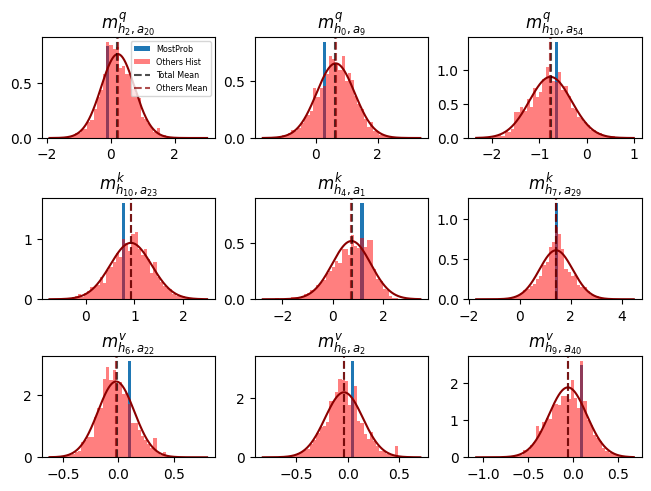

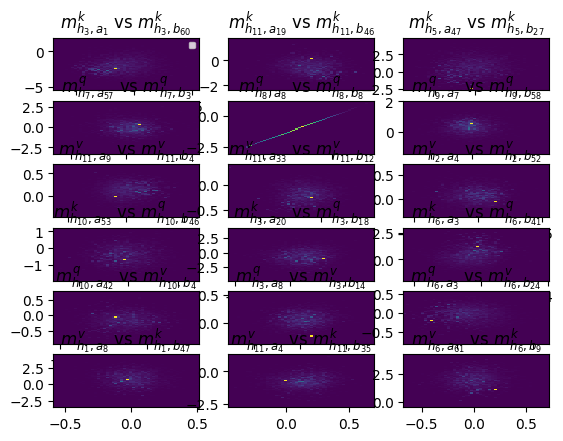

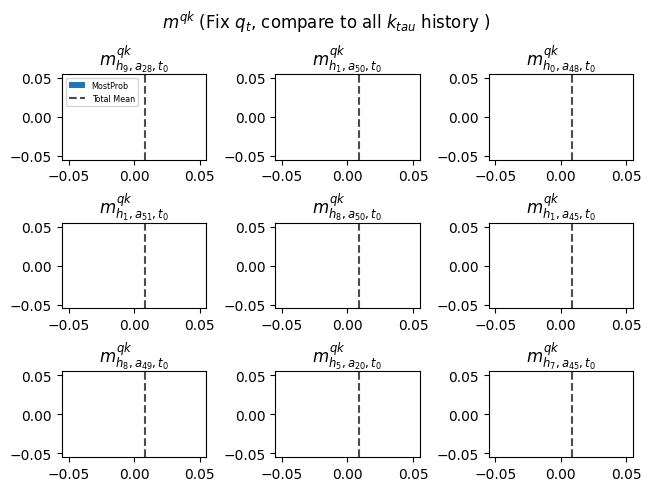

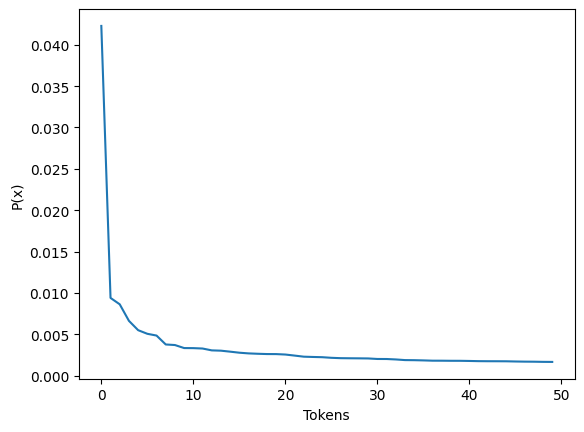

In [34]:
temperature = 1.4
explore_model(start, temperature, top_k)

T = 1.6

Computing samples  0 to 10000
Computing samples  10000 to 20000
Plot q 2 20 Unique 8392
Plot q 0 9 Unique 8393
Plot q 10 54 Unique 8387
Plot k 10 23 Unique 8390
Plot k 4 1 Unique 8392
Plot k 7 29 Unique 8388
Plot v 6 22 Unique 8393
Plot v 6 2 Unique 8393
Plot v 9 40 Unique 8393
Plot q 9 28 Unique 8393
Plot q 1 50 Unique 8393
Plot q 0 48 Unique 8393
Plot k 1 51 Unique 8393
Plot k 8 50 Unique 8393
Plot k 1 45 Unique 8393
Plot v 8 49 Unique 8393
Plot v 5 20 Unique 8393
Plot v 7 45 Unique 8393


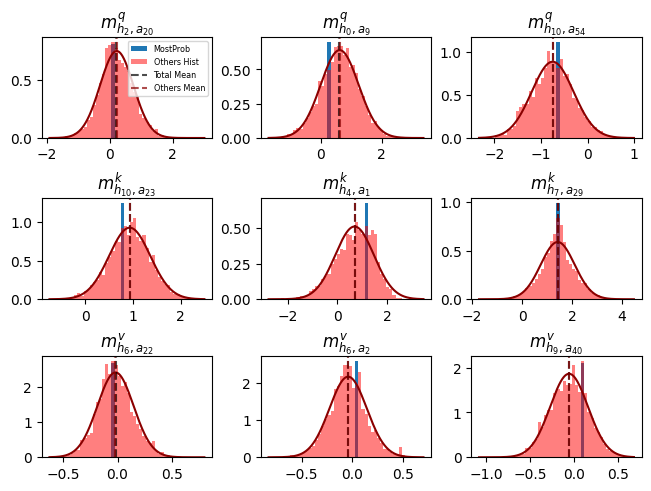

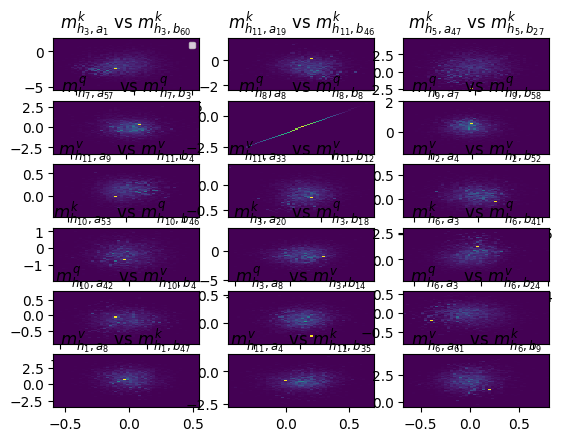

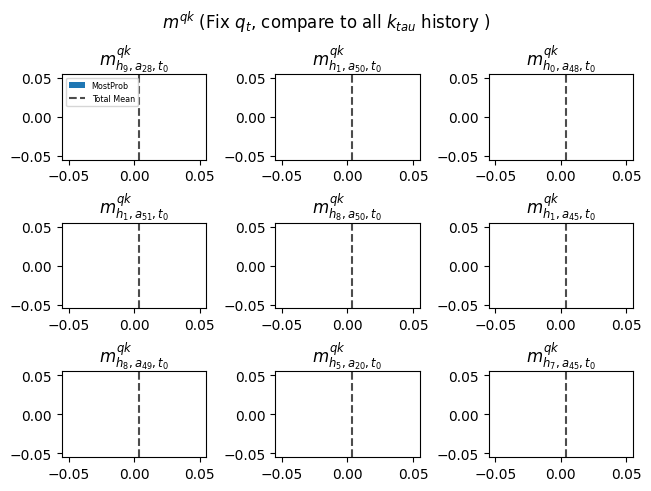

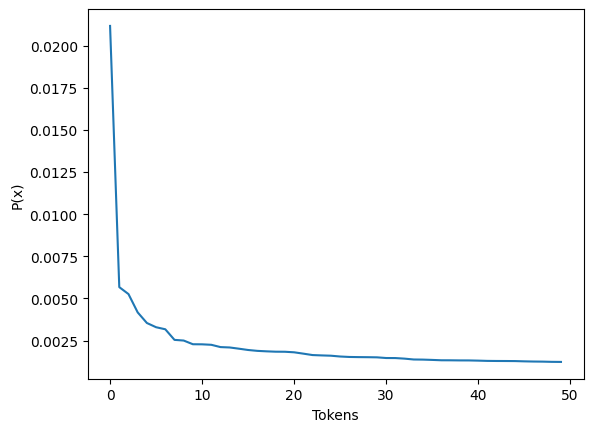

In [35]:
temperature = 1.6
explore_model(start, temperature, top_k)

### Short sentence 2 (cropped before)

In [36]:
start = "\nNeuroscience is the scientific study of the nervous system"
top_k = 20000

T = 0.8

Computing samples  0 to 10000
Computing samples  10000 to 20000
Plot q 2 20 Unique 100
Plot q 0 9 Unique 100
Plot q 10 54 Unique 100
Plot k 10 23 Unique 100
Plot k 4 1 Unique 100
Plot k 7 29 Unique 100
Plot v 6 22 Unique 100
Plot v 6 2 Unique 100
Plot v 9 40 Unique 100
Plot q 9 28 Unique 100
Plot q 1 50 Unique 100
Plot q 0 48 Unique 100
Plot k 1 51 Unique 100
Plot k 8 50 Unique 100
Plot k 1 45 Unique 100
Plot v 8 49 Unique 100
Plot v 5 20 Unique 100
Plot v 7 45 Unique 100


<ipython-input-28-a0c830be1693>:198: UserWarning: The figure layout has changed to tight
  fig.tight_layout()


Plot q 10 48 Unique 100
Plot q 8 27 Unique 100
Plot q 8 7 Unique 100
Plot k 9 20 Unique 100
Plot k 6 21 Unique 100
Plot k 2 44 Unique 100
Plot v 7 0 Unique 100
Plot v 0 52 Unique 100
Plot v 2 5 Unique 100


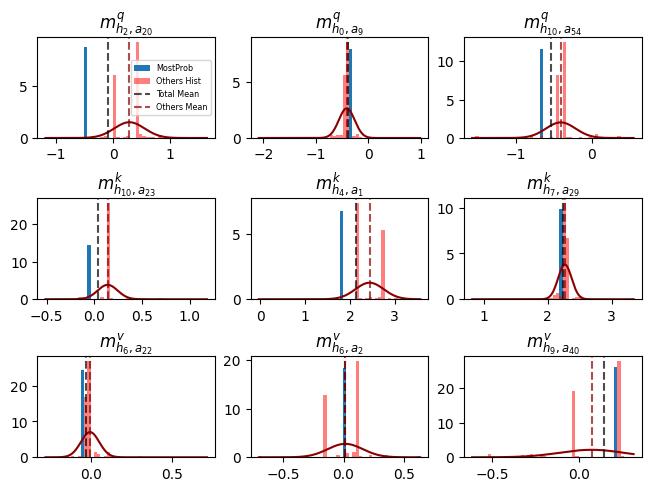

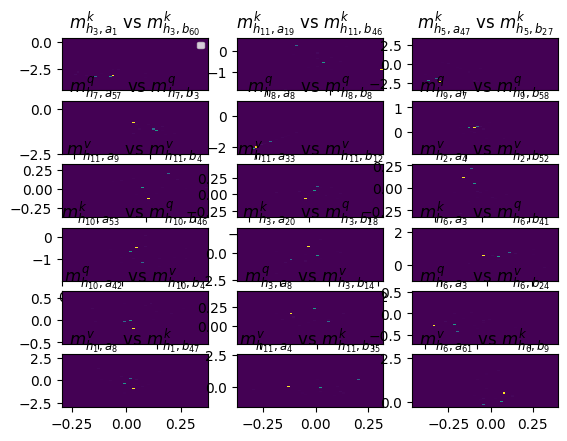

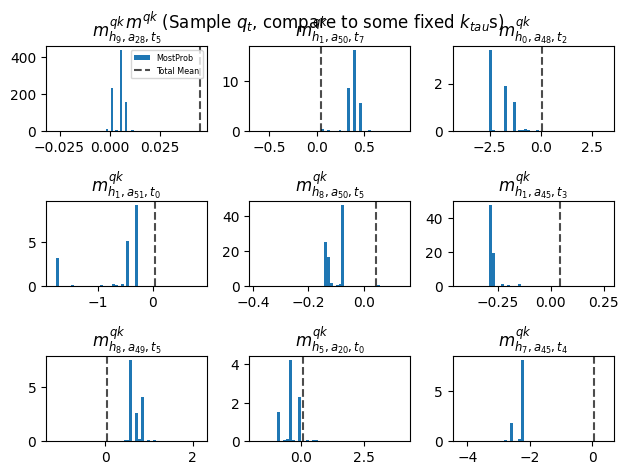

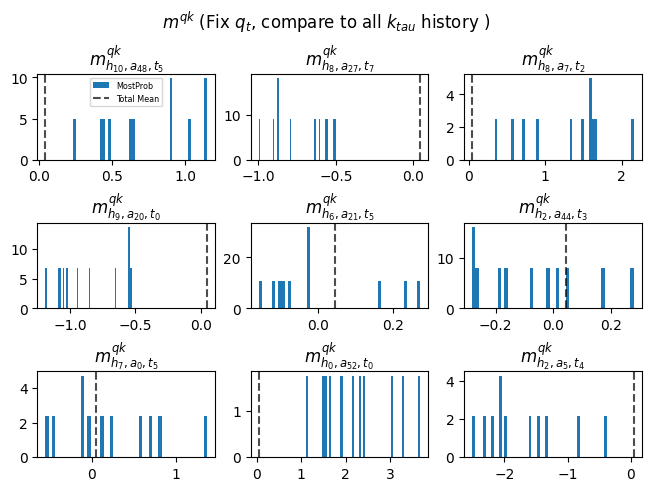

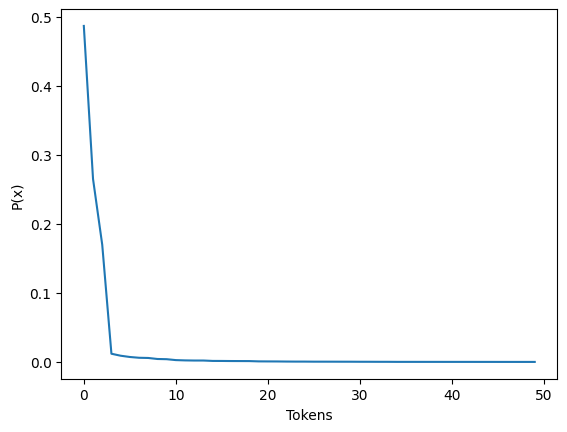

In [37]:
temperature = 0.8
explore_model(start, temperature, top_k)

T = 1

Computing samples  0 to 10000
Computing samples  10000 to 20000
Plot q 2 20 Unique 398
Plot q 0 9 Unique 398
Plot q 10 54 Unique 398
Plot k 10 23 Unique 398
Plot k 4 1 Unique 398
Plot k 7 29 Unique 398
Plot v 6 22 Unique 398
Plot v 6 2 Unique 398
Plot v 9 40 Unique 398
Plot q 9 28 Unique 398
Plot q 1 50 Unique 398
Plot q 0 48 Unique 398
Plot k 1 51 Unique 398
Plot k 8 50 Unique 398
Plot k 1 45 Unique 398
Plot v 8 49 Unique 398
Plot v 5 20 Unique 398
Plot v 7 45 Unique 398


<ipython-input-28-a0c830be1693>:198: UserWarning: The figure layout has changed to tight
  fig.tight_layout()


Plot q 10 48 Unique 398
Plot q 8 27 Unique 398
Plot q 8 7 Unique 398
Plot k 9 20 Unique 398
Plot k 6 21 Unique 398
Plot k 2 44 Unique 398
Plot v 7 0 Unique 398
Plot v 0 52 Unique 398
Plot v 2 5 Unique 398


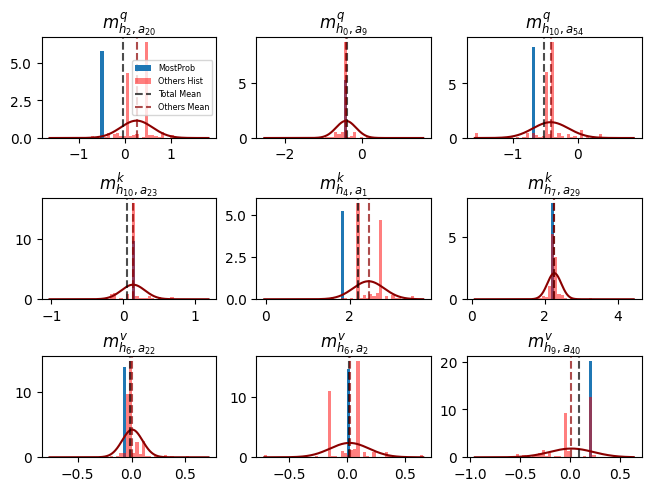

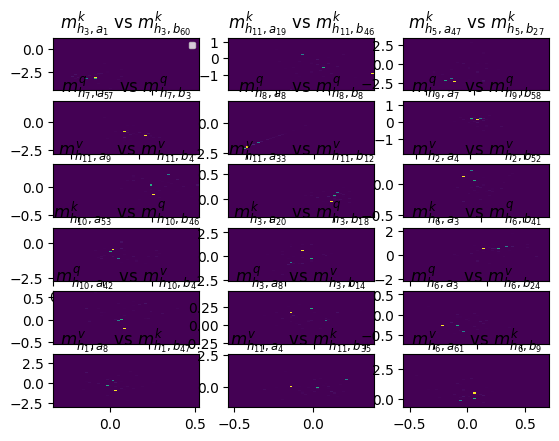

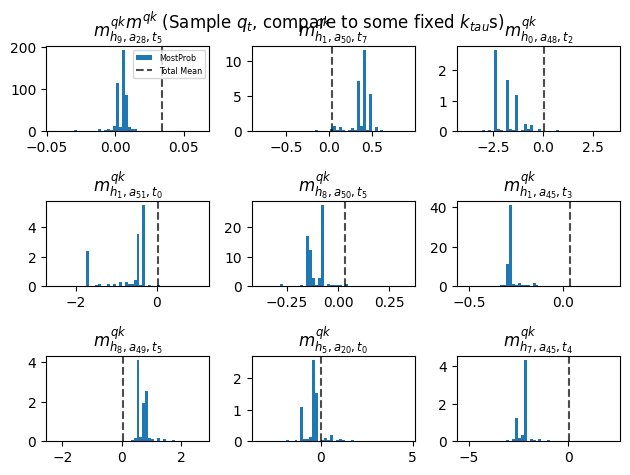

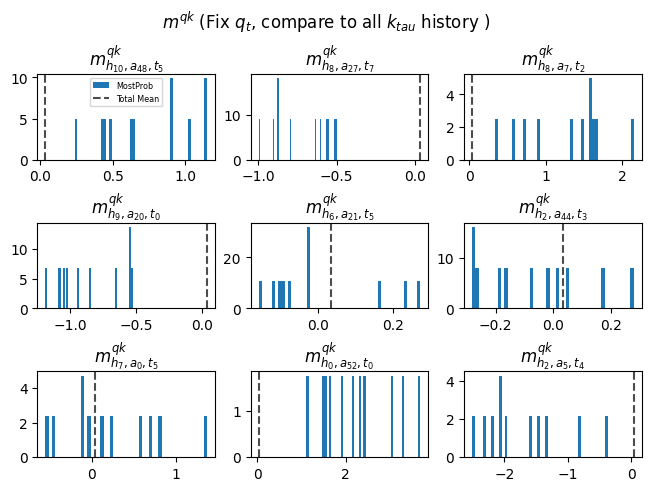

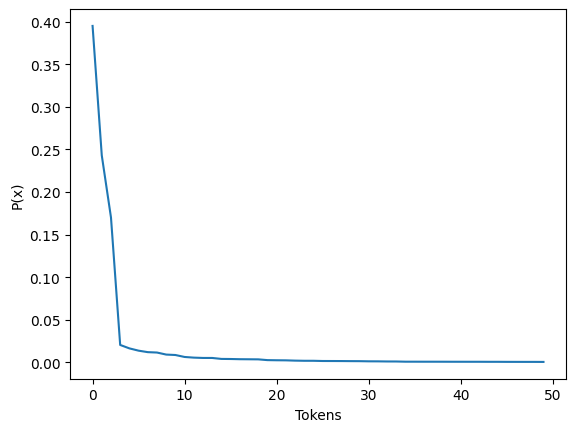

In [38]:
temperature = 1
explore_model(start, temperature, top_k)

T = 1.2

Computing samples  0 to 10000
Computing samples  10000 to 20000
Plot q 2 20 Unique 1091
Plot q 0 9 Unique 1091
Plot q 10 54 Unique 1091
Plot k 10 23 Unique 1091
Plot k 4 1 Unique 1091
Plot k 7 29 Unique 1091
Plot v 6 22 Unique 1091
Plot v 6 2 Unique 1091
Plot v 9 40 Unique 1091
Plot q 9 28 Unique 1091
Plot q 1 50 Unique 1091
Plot q 0 48 Unique 1091
Plot k 1 51 Unique 1091
Plot k 8 50 Unique 1091
Plot k 1 45 Unique 1091
Plot v 8 49 Unique 1091
Plot v 5 20 Unique 1091
Plot v 7 45 Unique 1091


<ipython-input-28-a0c830be1693>:198: UserWarning: The figure layout has changed to tight
  fig.tight_layout()


Plot q 10 48 Unique 1091
Plot q 8 27 Unique 1091
Plot q 8 7 Unique 1091
Plot k 9 20 Unique 1091
Plot k 6 21 Unique 1091
Plot k 2 44 Unique 1091
Plot v 7 0 Unique 1091
Plot v 0 52 Unique 1091
Plot v 2 5 Unique 1091


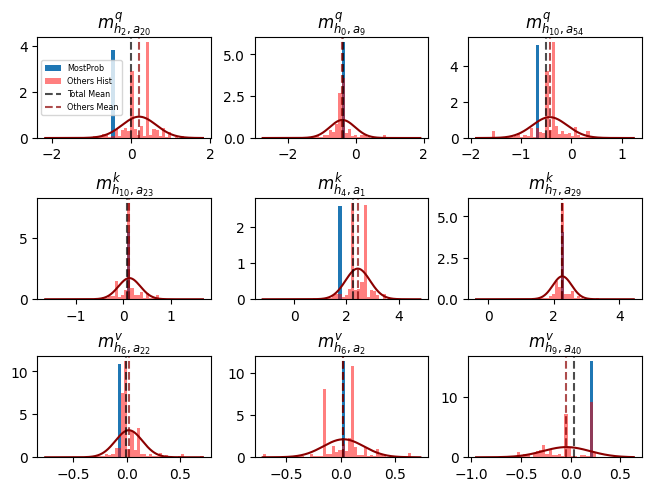

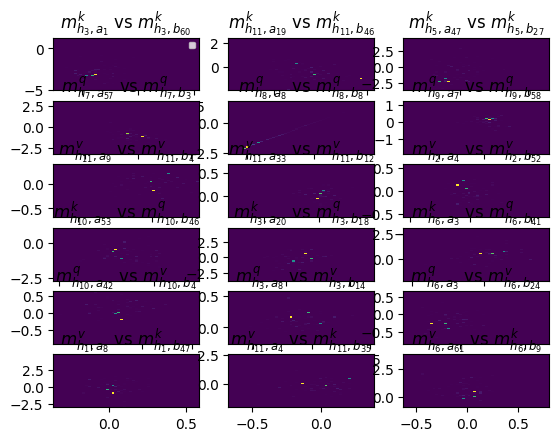

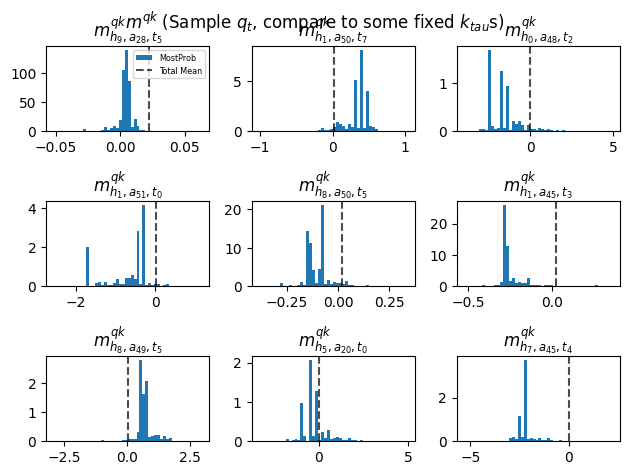

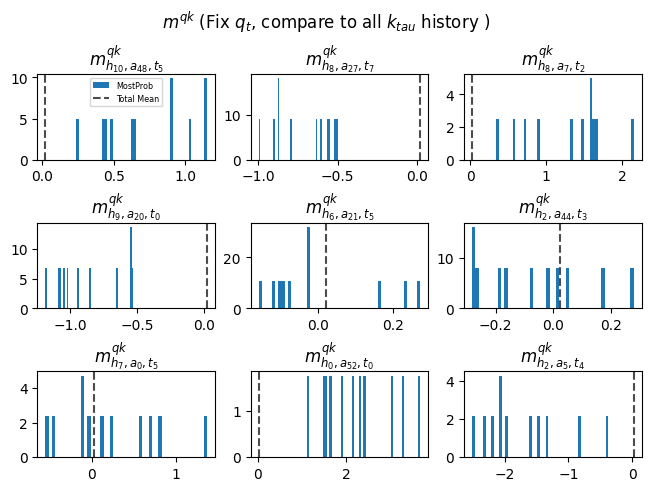

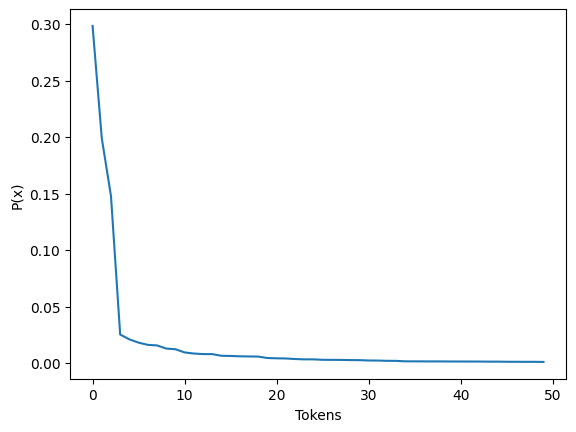

In [39]:
temperature = 1.2
explore_model(start, temperature, top_k)

T = 1.4

Computing samples  0 to 10000
Computing samples  10000 to 20000
Plot q 2 20 Unique 2408
Plot q 0 9 Unique 2408
Plot q 10 54 Unique 2408
Plot k 10 23 Unique 2408
Plot k 4 1 Unique 2408
Plot k 7 29 Unique 2408
Plot v 6 22 Unique 2408
Plot v 6 2 Unique 2408
Plot v 9 40 Unique 2408
Plot q 9 28 Unique 2408
Plot q 1 50 Unique 2408
Plot q 0 48 Unique 2408
Plot k 1 51 Unique 2408
Plot k 8 50 Unique 2408
Plot k 1 45 Unique 2408
Plot v 8 49 Unique 2408
Plot v 5 20 Unique 2408
Plot v 7 45 Unique 2408


<ipython-input-28-a0c830be1693>:198: UserWarning: The figure layout has changed to tight
  fig.tight_layout()


Plot q 10 48 Unique 2408
Plot q 8 27 Unique 2408
Plot q 8 7 Unique 2408
Plot k 9 20 Unique 2408
Plot k 6 21 Unique 2408
Plot k 2 44 Unique 2408
Plot v 7 0 Unique 2408
Plot v 0 52 Unique 2408
Plot v 2 5 Unique 2408


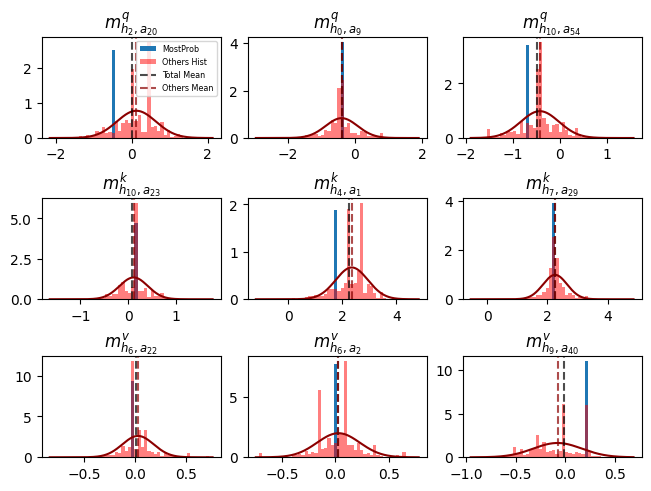

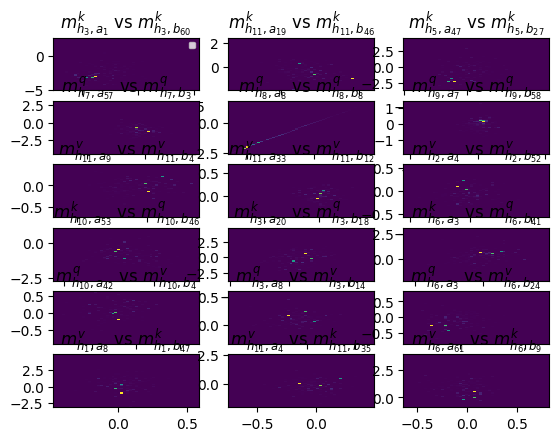

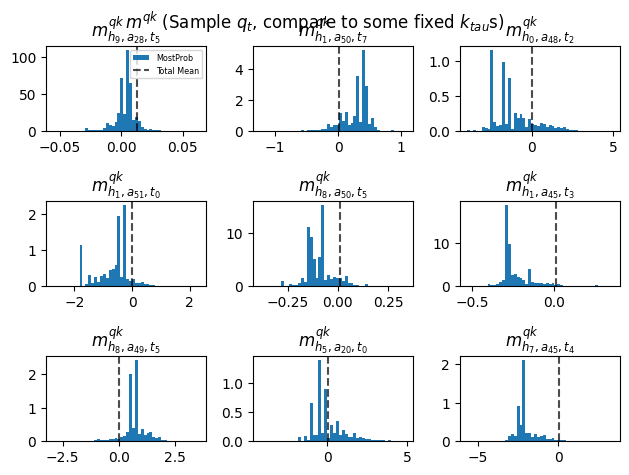

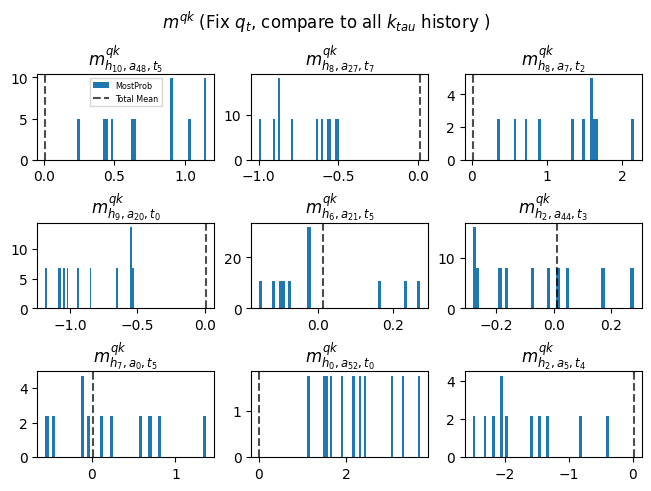

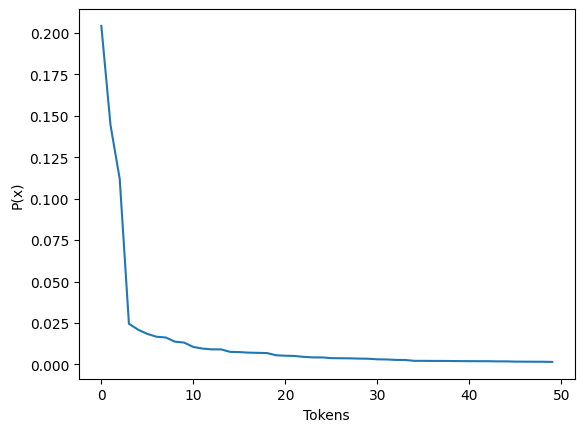

In [40]:
temperature = 1.4
explore_model(start, temperature, top_k)

T = 1.6

Computing samples  0 to 10000
Computing samples  10000 to 20000
Plot q 2 20 Unique 4109
Plot q 0 9 Unique 4109
Plot q 10 54 Unique 4109
Plot k 10 23 Unique 4109
Plot k 4 1 Unique 4109
Plot k 7 29 Unique 4108
Plot v 6 22 Unique 4109
Plot v 6 2 Unique 4109
Plot v 9 40 Unique 4109
Plot q 9 28 Unique 4109
Plot q 1 50 Unique 4109
Plot q 0 48 Unique 4109
Plot k 1 51 Unique 4109
Plot k 8 50 Unique 4109
Plot k 1 45 Unique 4109
Plot v 8 49 Unique 4109
Plot v 5 20 Unique 4109
Plot v 7 45 Unique 4109


<ipython-input-28-a0c830be1693>:198: UserWarning: The figure layout has changed to tight
  fig.tight_layout()


Plot q 10 48 Unique 4109
Plot q 8 27 Unique 4109
Plot q 8 7 Unique 4109
Plot k 9 20 Unique 4109
Plot k 6 21 Unique 4109
Plot k 2 44 Unique 4109
Plot v 7 0 Unique 4109
Plot v 0 52 Unique 4109
Plot v 2 5 Unique 4109


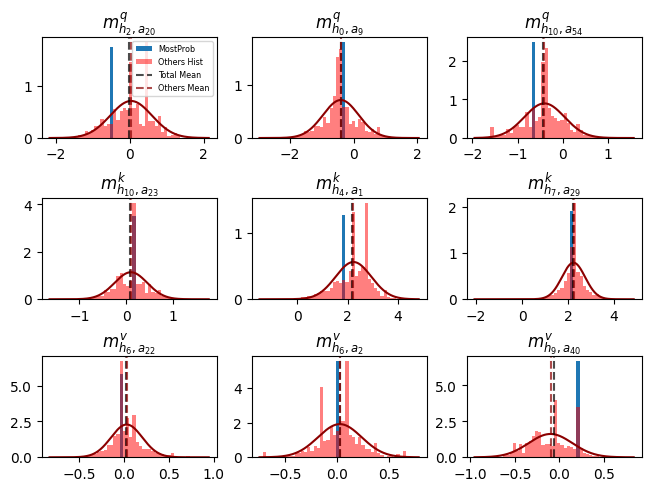

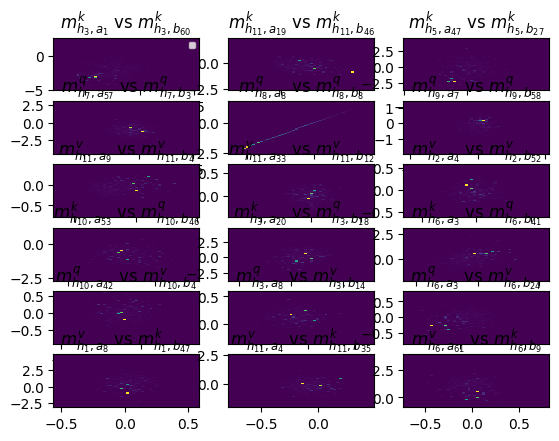

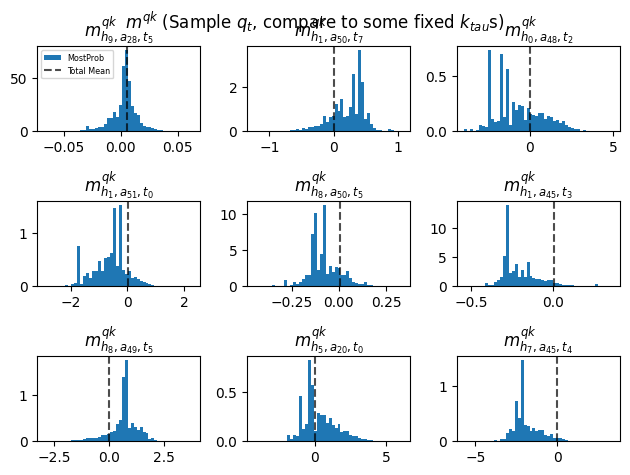

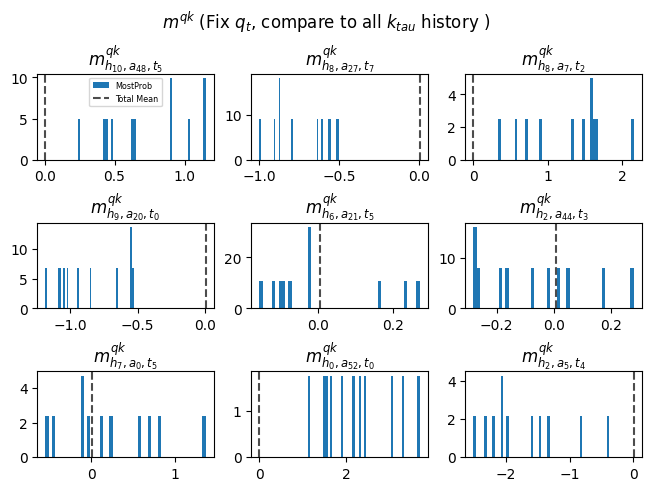

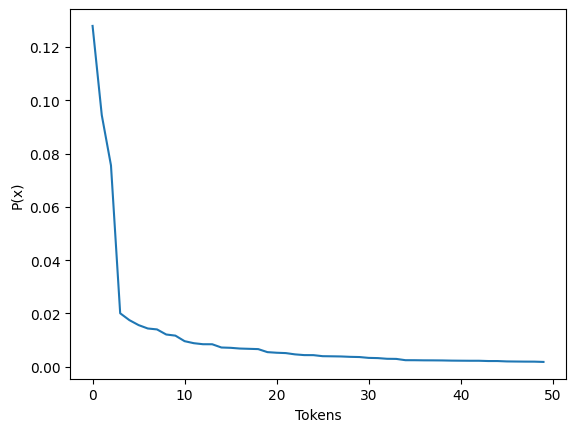

In [41]:
temperature = 1.6
explore_model(start, temperature, top_k)

### Long sample (sampled from GPT2)

In [42]:
start = "FILE:text_sample/sample_long_gpt2_2.txt"
top_k = 20000

T = 0.8

Computing samples  0 to 10000
Computing samples  10000 to 20000
Plot q 2 20 Unique 155
Plot q 0 9 Unique 155
Plot q 10 54 Unique 155
Plot k 10 23 Unique 155
Plot k 4 1 Unique 155
Plot k 7 29 Unique 155
Plot v 6 22 Unique 155
Plot v 6 2 Unique 155
Plot v 9 40 Unique 155
Plot q 9 28 Unique 155
Plot q 1 50 Unique 155
Plot q 0 48 Unique 155
Plot k 1 51 Unique 155
Plot k 8 50 Unique 155
Plot k 1 45 Unique 155
Plot v 8 49 Unique 155
Plot v 5 20 Unique 155
Plot v 7 45 Unique 155


<ipython-input-28-a0c830be1693>:198: UserWarning: The figure layout has changed to tight
  fig.tight_layout()


Plot q 10 48 Unique 155
Plot q 8 27 Unique 155
Plot q 8 7 Unique 155
Plot k 9 20 Unique 155
Plot k 6 21 Unique 155
Plot k 2 44 Unique 155
Plot v 7 0 Unique 155
Plot v 0 52 Unique 155
Plot v 2 5 Unique 155


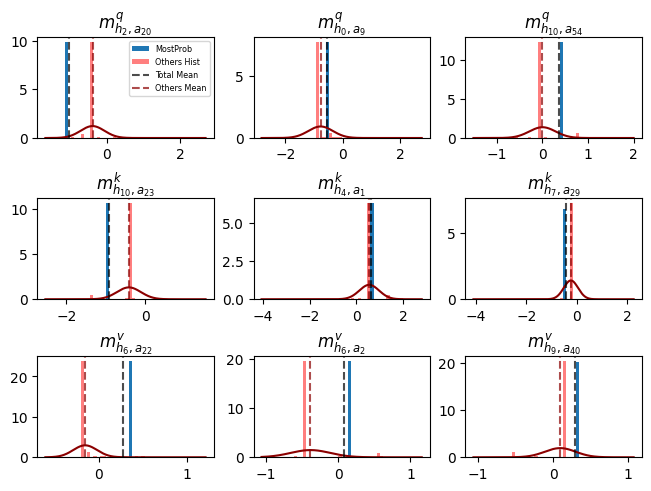

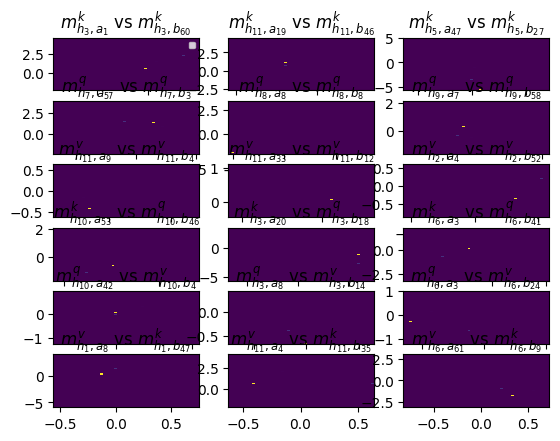

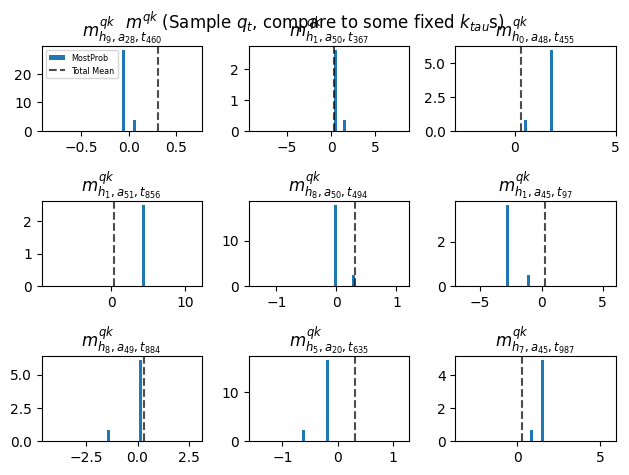

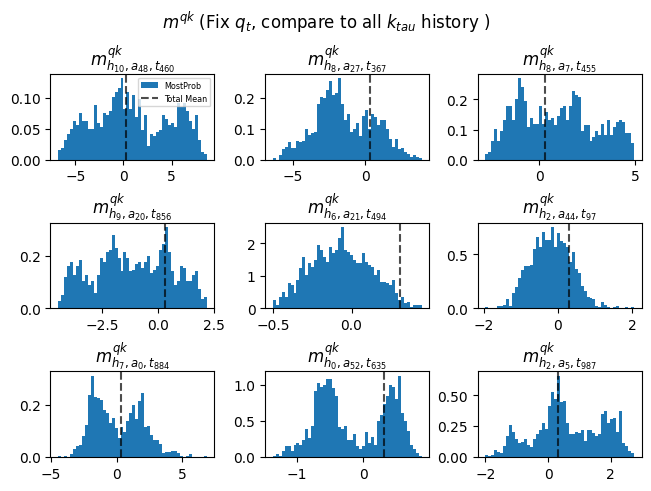

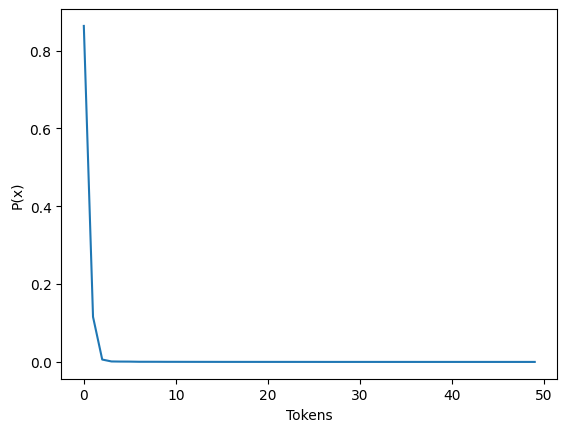

In [43]:
temperature = 0.8
explore_model(start, temperature, top_k)

T = 1

Computing samples  0 to 10000
Computing samples  10000 to 20000
Plot q 2 20 Unique 883
Plot q 0 9 Unique 883
Plot q 10 54 Unique 883
Plot k 10 23 Unique 883
Plot k 4 1 Unique 883
Plot k 7 29 Unique 883
Plot v 6 22 Unique 883
Plot v 6 2 Unique 883
Plot v 9 40 Unique 883
Plot q 9 28 Unique 883
Plot q 1 50 Unique 883
Plot q 0 48 Unique 883
Plot k 1 51 Unique 883
Plot k 8 50 Unique 883
Plot k 1 45 Unique 883
Plot v 8 49 Unique 883
Plot v 5 20 Unique 883
Plot v 7 45 Unique 883


<ipython-input-28-a0c830be1693>:198: UserWarning: The figure layout has changed to tight
  fig.tight_layout()


Plot q 10 48 Unique 883
Plot q 8 27 Unique 883
Plot q 8 7 Unique 883
Plot k 9 20 Unique 883
Plot k 6 21 Unique 883
Plot k 2 44 Unique 883
Plot v 7 0 Unique 883
Plot v 0 52 Unique 883
Plot v 2 5 Unique 883


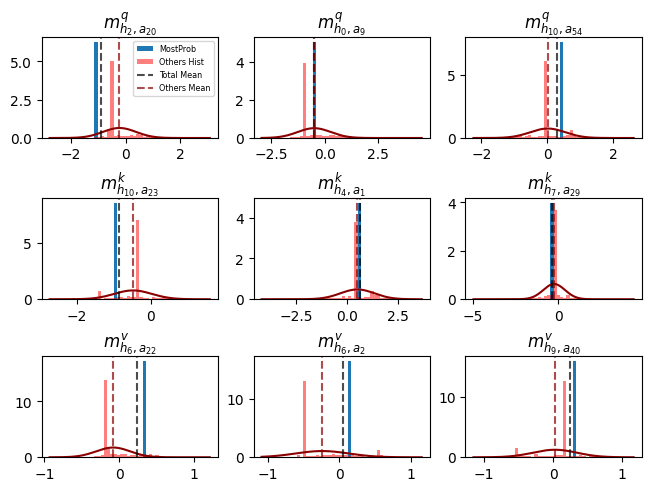

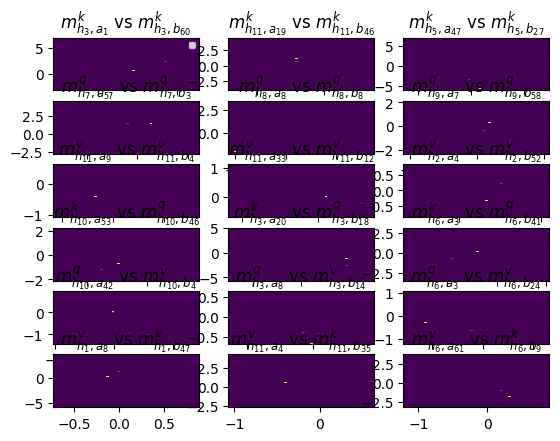

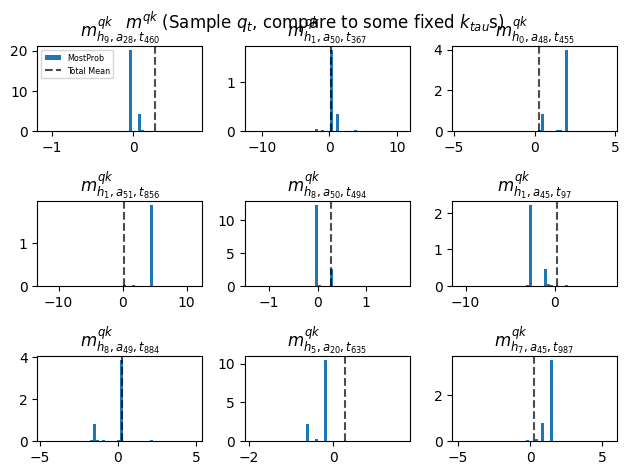

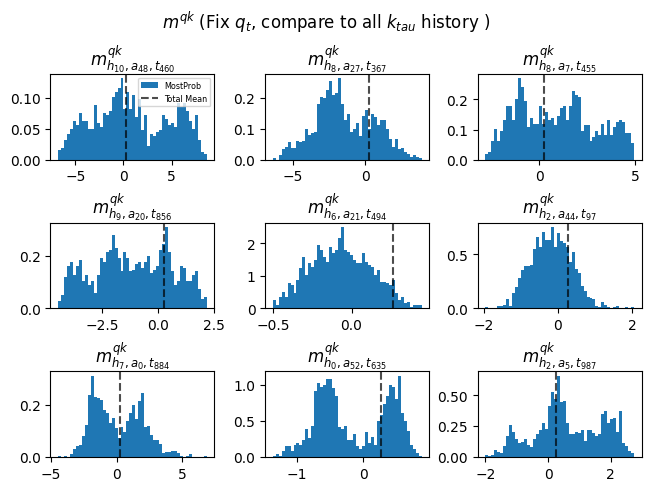

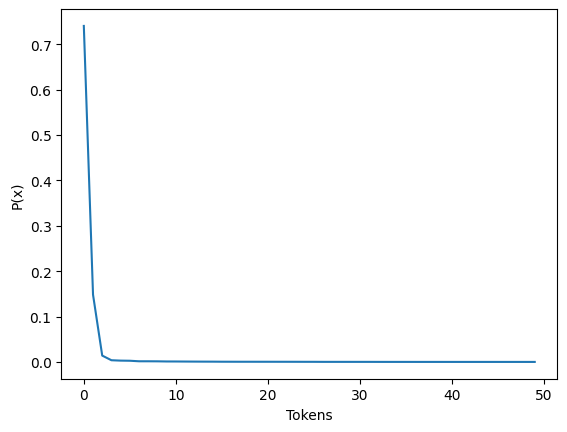

In [44]:
temperature = 1
explore_model(start, temperature, top_k)

T = 1.2

Computing samples  0 to 10000
Computing samples  10000 to 20000
Plot q 2 20 Unique 2725
Plot q 0 9 Unique 2725
Plot q 10 54 Unique 2725
Plot k 10 23 Unique 2725
Plot k 4 1 Unique 2725
Plot k 7 29 Unique 2725
Plot v 6 22 Unique 2725
Plot v 6 2 Unique 2725
Plot v 9 40 Unique 2725
Plot q 9 28 Unique 2725
Plot q 1 50 Unique 2725
Plot q 0 48 Unique 2725
Plot k 1 51 Unique 2725
Plot k 8 50 Unique 2725
Plot k 1 45 Unique 2725
Plot v 8 49 Unique 2725
Plot v 5 20 Unique 2725
Plot v 7 45 Unique 2725


<ipython-input-28-a0c830be1693>:198: UserWarning: The figure layout has changed to tight
  fig.tight_layout()


Plot q 10 48 Unique 2725
Plot q 8 27 Unique 2725
Plot q 8 7 Unique 2725
Plot k 9 20 Unique 2725
Plot k 6 21 Unique 2725
Plot k 2 44 Unique 2725
Plot v 7 0 Unique 2725
Plot v 0 52 Unique 2725
Plot v 2 5 Unique 2725


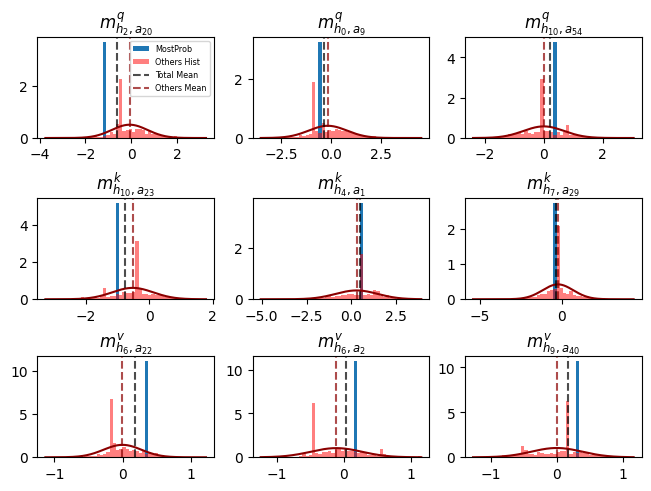

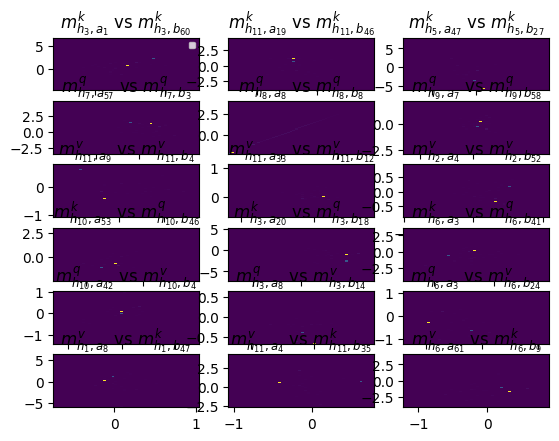

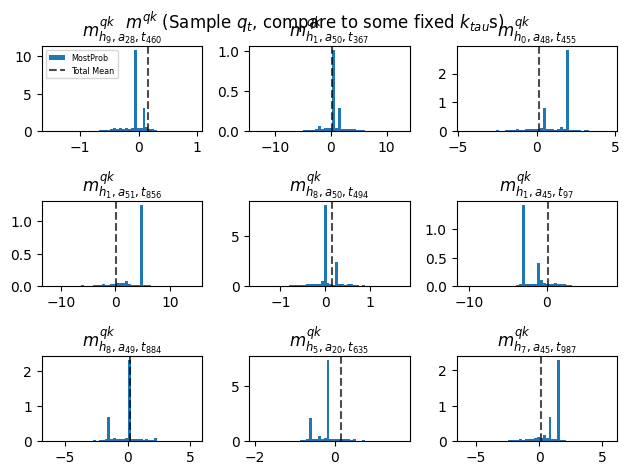

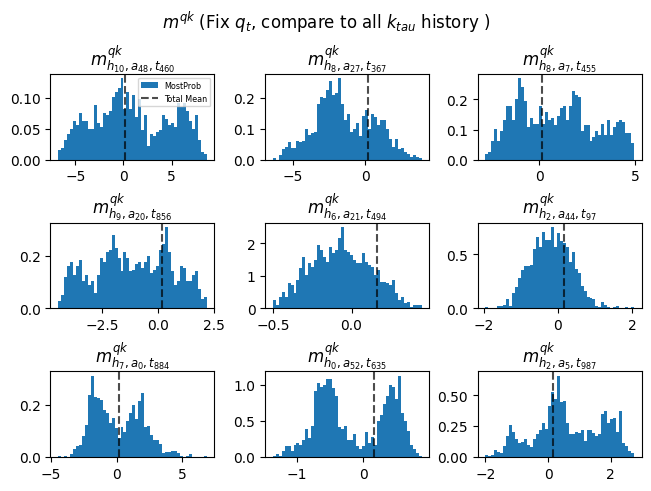

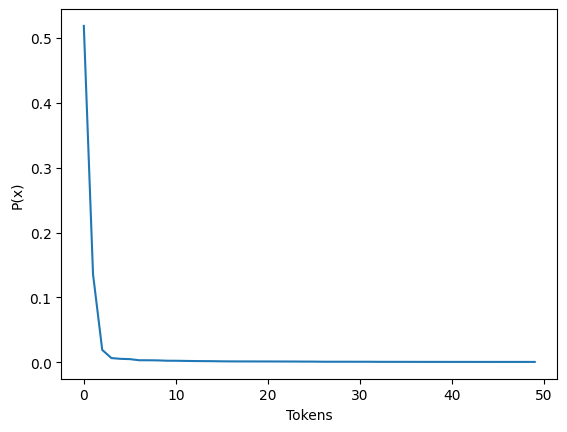

In [45]:
temperature = 1.2
explore_model(start, temperature, top_k)

T = 1.4

Computing samples  0 to 10000
Computing samples  10000 to 20000
Plot q 2 20 Unique 5102
Plot q 0 9 Unique 5101
Plot q 10 54 Unique 5102
Plot k 10 23 Unique 5102
Plot k 4 1 Unique 5102
Plot k 7 29 Unique 5102
Plot v 6 22 Unique 5102
Plot v 6 2 Unique 5102
Plot v 9 40 Unique 5102
Plot q 9 28 Unique 5102
Plot q 1 50 Unique 5102
Plot q 0 48 Unique 5102
Plot k 1 51 Unique 5102
Plot k 8 50 Unique 5102
Plot k 1 45 Unique 5102
Plot v 8 49 Unique 5102
Plot v 5 20 Unique 5102
Plot v 7 45 Unique 5102


<ipython-input-28-a0c830be1693>:198: UserWarning: The figure layout has changed to tight
  fig.tight_layout()


Plot q 10 48 Unique 5102
Plot q 8 27 Unique 5102
Plot q 8 7 Unique 5102
Plot k 9 20 Unique 5102
Plot k 6 21 Unique 5102
Plot k 2 44 Unique 5102
Plot v 7 0 Unique 5102
Plot v 0 52 Unique 5102
Plot v 2 5 Unique 5102


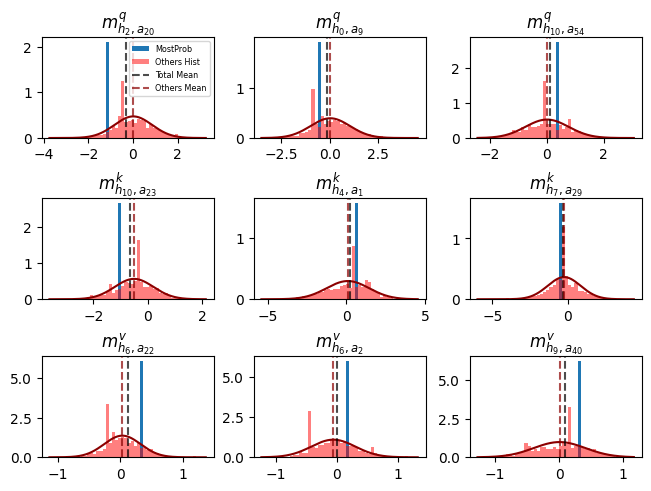

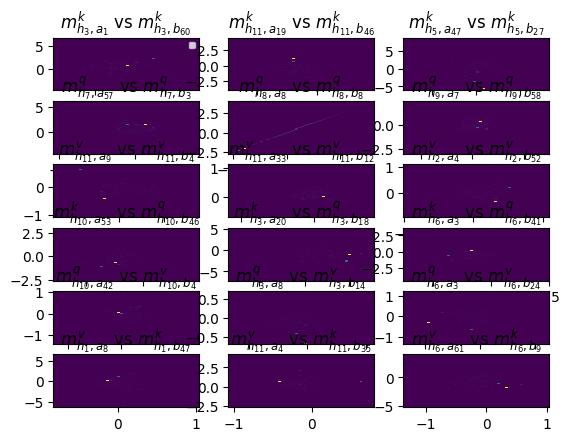

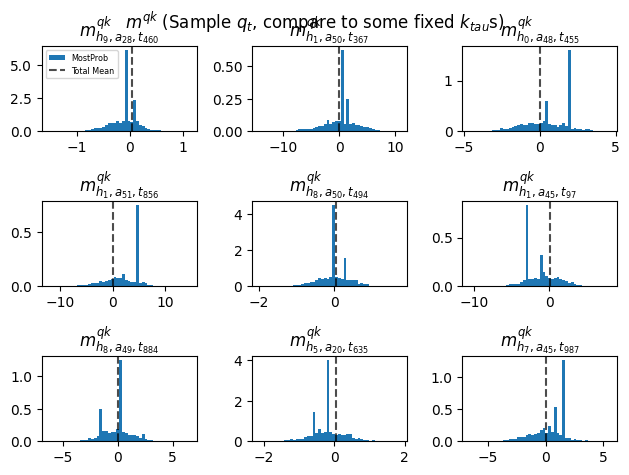

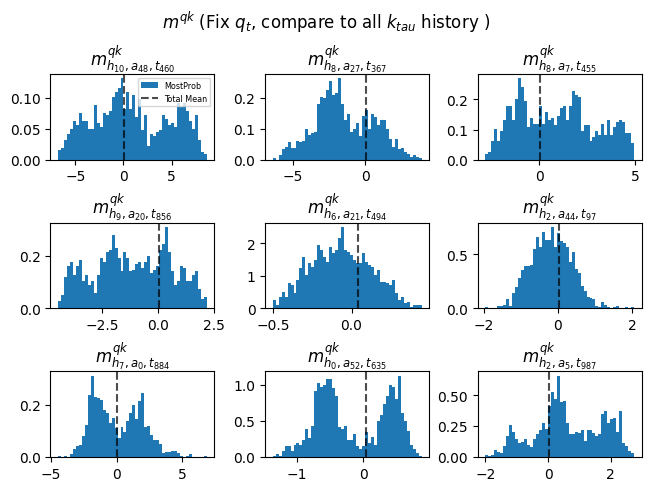

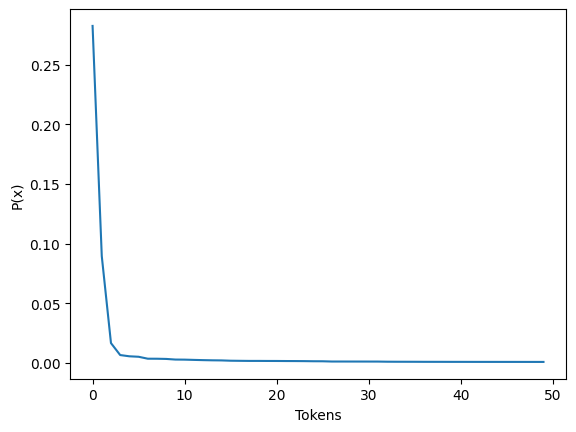

In [46]:
temperature = 1.4
explore_model(start, temperature, top_k)

T = 1.6

Computing samples  0 to 10000
Computing samples  10000 to 20000
Plot q 2 20 Unique 7011
Plot q 0 9 Unique 7010
Plot q 10 54 Unique 7011
Plot k 10 23 Unique 7011
Plot k 4 1 Unique 7011
Plot k 7 29 Unique 7011
Plot v 6 22 Unique 7011
Plot v 6 2 Unique 7011
Plot v 9 40 Unique 7011
Plot q 9 28 Unique 7011
Plot q 1 50 Unique 7011
Plot q 0 48 Unique 7011
Plot k 1 51 Unique 7011
Plot k 8 50 Unique 7011
Plot k 1 45 Unique 7011
Plot v 8 49 Unique 7011
Plot v 5 20 Unique 7011
Plot v 7 45 Unique 7011


<ipython-input-28-a0c830be1693>:198: UserWarning: The figure layout has changed to tight
  fig.tight_layout()


Plot q 10 48 Unique 7011
Plot q 8 27 Unique 7011
Plot q 8 7 Unique 7011
Plot k 9 20 Unique 7011
Plot k 6 21 Unique 7011
Plot k 2 44 Unique 7011
Plot v 7 0 Unique 7011
Plot v 0 52 Unique 7011
Plot v 2 5 Unique 7011


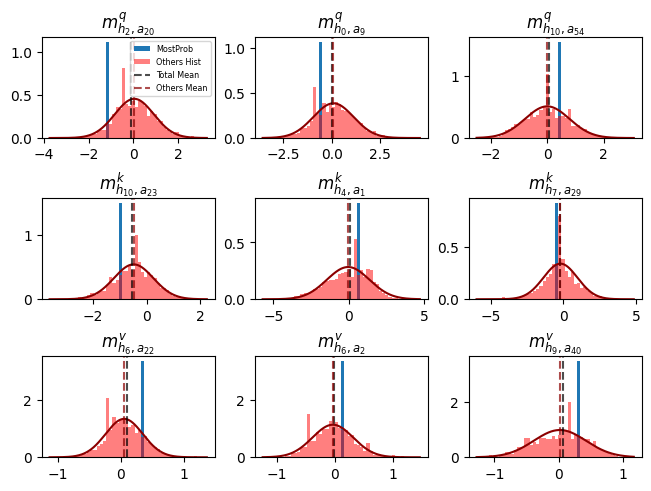

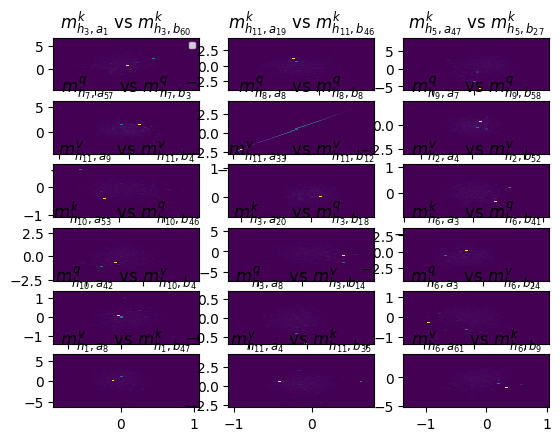

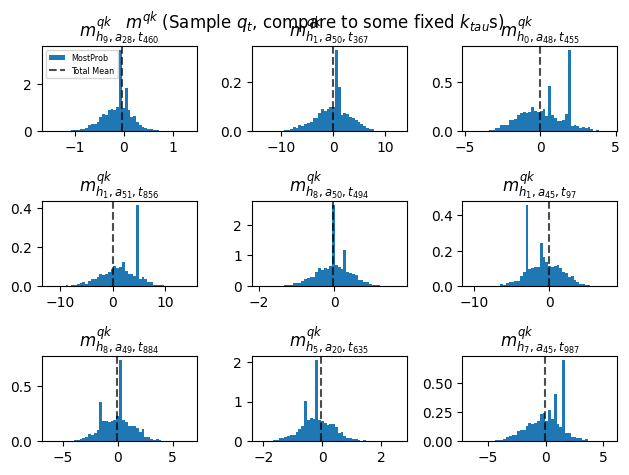

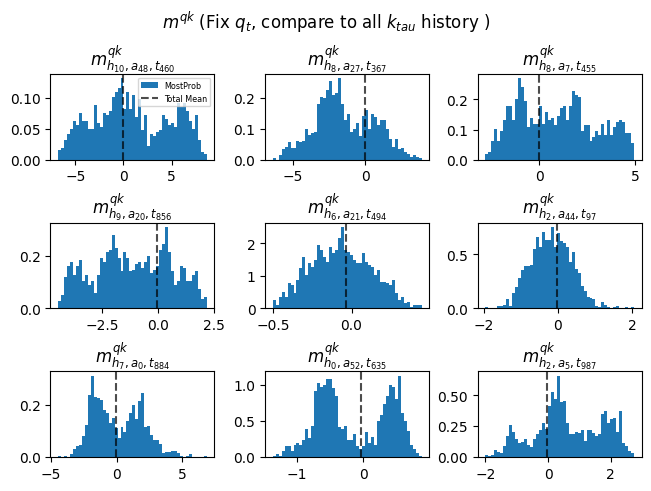

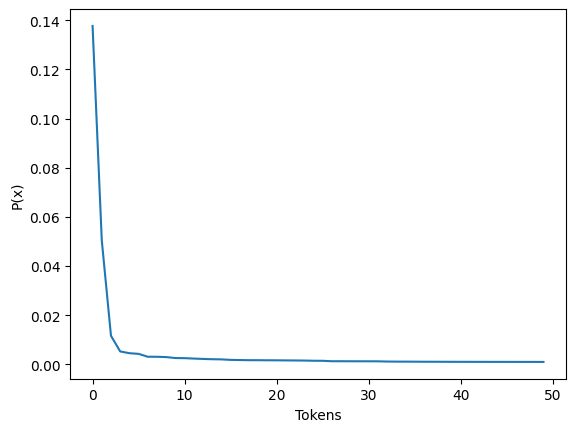

In [47]:
temperature = 1.6
explore_model(start, temperature, top_k)

### Other tests: